<a href="https://colab.research.google.com/github/kanru-wang/Udemy_GAN_and_Diffusion_models/blob/main/CelebA_SRGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CelebA SRGAN

Super Resolution GAN trained on the CelebA dataset for generating facial images.

In [1]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Layer, Reshape, LeakyReLU, Dropout, Conv2DTranspose, Add, Conv2D, MaxPool2D,
    Dense, Flatten, InputLayer, BatchNormalization, Input, GlobalAvgPool2D, PReLU
)
from tensorflow.keras.optimizers import Adam

# Data

## Data Download

Before running the following cell, must first log into Kaggle, go to `Settings -> API -> Create New Token`.

Download `kaggle.json` and upload it to the root folder of Colab.

In [2]:
# suppress output
%%capture
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json
! kaggle datasets download -d badasstechie/celebahq-resized-256x256
! unzip "/content/celebahq-resized-256x256.zip" -d "/content/dataset/"

## Data Preparation

In [3]:
BATCH_SIZE = 128
IM_SHAPE = (64, 64, 3)
B = 24  # Number of residual blocks
LEARNING_RATE = 1e-4

ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/dataset/celeba_hq_256",
    label_mode=None,
    image_size=(IM_SHAPE[0], IM_SHAPE[1]),
    batch_size=BATCH_SIZE
)

ds

Found 30000 files belonging to 1 classes.


<_BatchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

In [4]:
def preprocess(image):
    return (
        # For low resolution images, convert the values to a range between 0 and 1
        tf.image.resize(image, [IM_SHAPE[0] // 4, IM_SHAPE[1] // 4], method='bicubic') / 255,
        # For high resolution images, convert the values to a range between -1 and 1
        tf.cast(image, tf.float32) / 127.5 - 1.0
    )

train_dataset = (
    ds.take(12000)
    .map(preprocess)
    .unbatch()
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

for d1, d2 in train_dataset.take(1):
    print(d1.shape, d2.shape)

(128, 16, 16, 3) (128, 64, 64, 3)


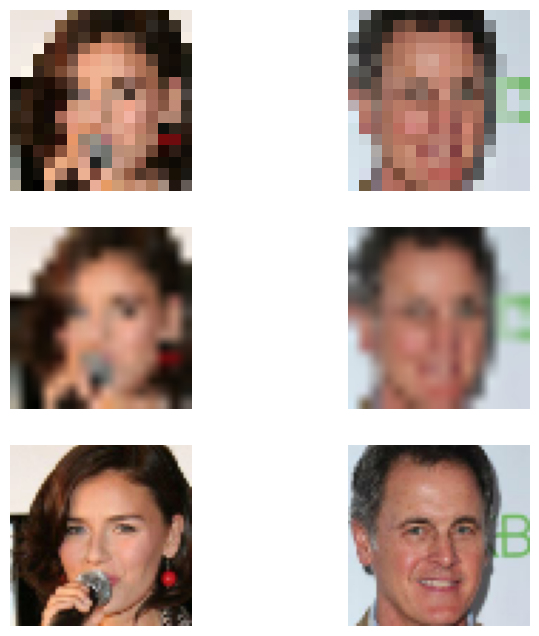

In [5]:
plt.figure(figsize=(8, 8))
k = 0
n = 6
for i in range(n):
    ax = plt.subplot(3, 2, k + 1)
    if i < 2:
        plt.imshow(d1[i])
    elif i >= 2 and i < 4:
        # Resizing low resolution images to high resolution
        plt.imshow(cv2.resize(np.array(d1[i - 2]), (64, 64)))
    else:
        plt.imshow((d2[i - 4] + 1) / 2)
    plt.axis("off")
    k += 1

# Modeling

## Generator

In [6]:
class ResBlock(Layer):
    def __init__(self, n_filters, filter_size, strides, name='res_block'):
        super(ResBlock, self).__init__(name=name)
        self.n_filters = n_filters
        self.filter_size = filter_size
        self.strides = strides

    def build(self, input_shape):
        self.conv_1 = Conv2D(self.n_filters, self.filter_size, strides=self.strides, padding='same')
        self.batch_norm_1 = BatchNormalization()
        self.prelu = PReLU()
        self.conv_2 = Conv2D(self.n_filters, self.filter_size, strides=self.strides, padding='same')
        self.batch_norm_2 = BatchNormalization()

    def call(self, x_in):
        x = self.conv_1(x_in)
        x = self.prelu(self.batch_norm_1(x))
        x = self.conv_2(x)
        x = self.batch_norm_2(x)
        return x + x_in


class UpsampleBlock(Layer):
    def __init__(self, n_filters, filter_size, strides, name='upsample_block'):
        super(UpsampleBlock, self).__init__(name=name)
        self.n_filters = n_filters
        self.filter_size = filter_size
        self.strides = strides

    def build(self, input_shape):
        self.conv = Conv2D(self.n_filters, self.filter_size, strides=self.strides, padding='same')
        self.prelu = PReLU()

    def call(self,x):
        x = self.conv(x)
        x = tf.nn.depth_to_space(x, 2)
        x = self.prelu(x)
        return x

In [7]:
input_lr = tf.keras.layers.Input(shape=(IM_SHAPE[0] // 4, IM_SHAPE[1] // 4, 3))
input_conv = tf.keras.layers.Conv2D(64, 9, 1, padding='same')(input_lr)
input_conv = PReLU()(input_conv)

x = input_conv
for i in range(B):
    x = ResBlock(64, 3, 1, name='res_block_' + str(i))(x)
x = tf.keras.layers.Conv2D(64, 9, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)

x += input_conv

x = UpsampleBlock(256, 3, 1, name='upsample_block_1')(x)
x = UpsampleBlock(256, 3, 1, name='upsample_block_2')(x)
output_sr = tf.keras.layers.Conv2D(3, 9, activation='tanh', padding='same')(x)

srresnet = tf.keras.models.Model(input_lr, output_sr)
srresnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 16, 16, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 64)   15616       ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 16, 16, 64)   16384       ['conv2d[0][0]']                 
                                                                                                  
 res_block_0 (ResBlock)         (None, 16, 16, 64)   90752       ['p_re_lu[0][0]']                
                                                                                              

## Discriminator

In [8]:
class ConvBlock(Layer):
    def __init__(self, n_filters, filter_size, strides, name='conv_block'):
        super(ConvBlock, self).__init__(name=name)
        self.n_filters = n_filters
        self.filter_size = filter_size
        self.strides = strides

    def build(self, input_shape):
        self.conv = Conv2D(self.n_filters, self.filter_size, strides=self.strides, padding='same')
        self.batch_norm = BatchNormalization()

    def call(self, x):
        x = self.conv(x)
        x = LeakyReLU()(self.batch_norm(x))
        return x

In [9]:
input_lr = tf.keras.layers.Input(shape=(IM_SHAPE[0], IM_SHAPE[1], 3))
input_conv = tf.keras.layers.Conv2D(64, 3, padding='same')(input_lr)
input_conv = tf.keras.layers.LeakyReLU()(input_conv)

channel_nums = [64, 128, 128, 256, 256, 512, 512]
stride_sizes = [2, 1, 2, 1, 2, 1, 2]

disc = input_conv
for i in range(7):
    disc=ConvBlock(channel_nums[i], 3, stride_sizes[i], name='conv_block_' + str(i))(disc)
disc = GlobalAvgPool2D()(disc)
disc = tf.keras.layers.Dense(1024)(disc)
disc = tf.keras.layers.LeakyReLU()(disc)

disc_output = tf.keras.layers.Dense(1, activation='sigmoid')(disc)

discriminator = tf.keras.models.Model(input_lr, disc_output)
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 64)        0         
                                                                 
 conv_block_0 (ConvBlock)    (None, 32, 32, 64)        37184     
                                                                 
 conv_block_1 (ConvBlock)    (None, 32, 32, 128)       74368     
                                                                 
 conv_block_2 (ConvBlock)    (None, 16, 16, 128)       148096    
                                                                 
 conv_block_3 (ConvBlock)    (None, 16, 16, 256)       2961

## Together

In [10]:
VGG19 = tf.keras.applications.VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=(256, 256, 3)
)


def VGG_loss(y_hr, y_sr, i_m=2, j_m=2):
    """
    j-th convolution, i-th maxpooling layer, within VGG19
    """
    i, j = 0, 0
    accumulated_loss = 0
    for l in VGG19.layers:
        cl_name = l.__class__.__name__
        if cl_name == 'Conv2D':
            j += 1
        if cl_name == 'MaxPooling2D':
            i += 1
            j = 0
        if i == i_m and j == j_m:
            break
        y_hr = l(y_hr)
        y_sr = l(y_sr)
        if cl_name == 'Conv2D':
            mse = tf.keras.losses.MeanSquaredError(name='mean_squared_error')
            accumulated_loss += mse(y_hr, y_sr) * 0.006
    return accumulated_loss


def content_loss(y_true,y_pred):
    mse = tf.keras.losses.MeanSquaredError(name='mean_squared_error')
    return mse(y_true, y_pred) + VGG_loss(y_true, y_pred)


class GANMonitor(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        plt.figure(figsize=(16, 16))
        k = 0
        n = 6
        for i in range(n):
            ax = plt.subplot(3, 2, k+1)
            if i < 2:
                plt.imshow(d1[i])
            elif i >= 2 and i < 4:
                # Hope these 2 images to be as close as possible to the next 2 images
                out = self.model.generator(tf.expand_dims(d1[i - 2], axis=0))
                plt.imshow((out[0] + 1) / 2)
            else:
                plt.imshow((d2[i - 4] + 1) / 2)
            plt.axis("off")
            k += 1
        plt.savefig("generated/gen_images_epoch_{}.png".format(epoch + 1))


class SRGAN(tf.keras.Model):
    def __init__(self, discriminator, generator):
        super(SRGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator

    def compile(self, d_optimizer, g_optimizer, loss_disc, loss_gen):
        super(SRGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_disc = loss_disc
        self.loss_gen = loss_gen
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        lr_images, hr_images = real_images
        batch_size = tf.shape(hr_images)[0]
        generated_images = self.generator(lr_images)
        real_labels = tf.ones((batch_size, 1))
        fake_labels = tf.zeros((batch_size, 1))
        # Train the discriminator
        with tf.GradientTape() as tape:
            real_predictions = self.discriminator(hr_images)
            d_loss_real = self.loss_disc(real_labels, real_predictions)
            fake_predictions = self.discriminator(generated_images)
            d_loss_fake = self.loss_disc(fake_labels, fake_predictions)
            d_loss = 0.5 * (d_loss_fake + d_loss_real)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))
        misleading_labels = tf.ones((batch_size, 1))
        with tf.GradientTape() as tape:
            predictions = self.generator(lr_images)
            g_loss = self.loss_gen(hr_images, predictions)
            g_loss = g_loss + 1e-3 * self.loss_disc(misleading_labels, self.discriminator(predictions))
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

80134624/80134624 [==============================] - 2s 0us/step


# Training

Epoch 1/36
    234/Unknown - 244s 705ms/step - d_loss: 0.4594 - g_loss: 0.3791

234/234 [==============================] - 245s 709ms/step - d_loss: 0.4594 - g_loss: 0.3791
Epoch 2/36
234/234 [==============================] - ETA: 0s - d_loss: 0.1174 - g_loss: 0.2287

234/234 [==============================] - 175s 746ms/step - d_loss: 0.1174 - g_loss: 0.2287
Epoch 3/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0834 - g_loss: 0.1947

234/234 [==============================] - 176s 745ms/step - d_loss: 0.0834 - g_loss: 0.1947
Epoch 4/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0332 - g_loss: 0.1790

234/234 [==============================] - 175s 741ms/step - d_loss: 0.0332 - g_loss: 0.1790
Epoch 5/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0420 - g_loss: 0.1684

234/234 [==============================] - 175s 739ms/step - d_loss: 0.0420 - g_loss: 0.1684
Epoch 6/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0390 - g_loss: 0.1604

234/234 [==============================] - 174s 740ms/step - d_loss: 0.0390 - g_loss: 0.1604
Epoch 7/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0255 - g_loss: 0.1560

234/234 [==============================] - 174s 739ms/step - d_loss: 0.0255 - g_loss: 0.1560
Epoch 8/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0277 - g_loss: 0.1511

234/234 [==============================] - 174s 740ms/step - d_loss: 0.0277 - g_loss: 0.1511
Epoch 9/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0141 - g_loss: 0.1493

234/234 [==============================] - 174s 739ms/step - d_loss: 0.0141 - g_loss: 0.1493
Epoch 10/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0477 - g_loss: 0.1451

234/234 [==============================] - 174s 741ms/step - d_loss: 0.0477 - g_loss: 0.1451
Epoch 11/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0382 - g_loss: 0.1428

234/234 [==============================] - 174s 742ms/step - d_loss: 0.0382 - g_loss: 0.1428
Epoch 12/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0277 - g_loss: 0.1413

234/234 [==============================] - 174s 739ms/step - d_loss: 0.0277 - g_loss: 0.1413
Epoch 13/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0390 - g_loss: 0.1389

234/234 [==============================] - 174s 741ms/step - d_loss: 0.0390 - g_loss: 0.1389
Epoch 14/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0312 - g_loss: 0.1348

234/234 [==============================] - 174s 740ms/step - d_loss: 0.0312 - g_loss: 0.1348
Epoch 15/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0222 - g_loss: 0.1357

234/234 [==============================] - 175s 743ms/step - d_loss: 0.0222 - g_loss: 0.1357
Epoch 16/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0257 - g_loss: 0.1341

234/234 [==============================] - 175s 741ms/step - d_loss: 0.0257 - g_loss: 0.1341
Epoch 17/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0258 - g_loss: 0.1322

234/234 [==============================] - 175s 741ms/step - d_loss: 0.0258 - g_loss: 0.1322
Epoch 18/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0569 - g_loss: 0.1295

234/234 [==============================] - 175s 742ms/step - d_loss: 0.0569 - g_loss: 0.1295
Epoch 19/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0266 - g_loss: 0.1302

234/234 [==============================] - 174s 741ms/step - d_loss: 0.0266 - g_loss: 0.1302
Epoch 20/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0333 - g_loss: 0.1286

234/234 [==============================] - 174s 742ms/step - d_loss: 0.0333 - g_loss: 0.1286
Epoch 21/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0314 - g_loss: 0.1276

<ipython-input-10-0eb83be3c7f6>:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(16, 16))


234/234 [==============================] - 174s 742ms/step - d_loss: 0.0314 - g_loss: 0.1276
Epoch 22/36
234/234 [==============================] - ETA: 0s - d_loss: 0.0317 - g_loss: 0.1270

234/234 [==============================] - 175s 744ms/step - d_loss: 0.0317 - g_loss: 0.1270
Epoch 23/36
234/234 [==============================] - ETA: 0s - d_loss: 0.2647 - g_loss: 0.3538

234/234 [==============================] - 174s 740ms/step - d_loss: 0.2647 - g_loss: 0.3538
Epoch 24/36
234/234 [==============================] - ETA: 0s - d_loss: 8.4397e-04 - g_loss: 1.4458

234/234 [==============================] - 171s 729ms/step - d_loss: 8.4397e-04 - g_loss: 1.4458
Epoch 25/36
234/234 [==============================] - ETA: 0s - d_loss: 2.0763e-04 - g_loss: 1.4474

234/234 [==============================] - 171s 725ms/step - d_loss: 2.0763e-04 - g_loss: 1.4474
Epoch 26/36
234/234 [==============================] - ETA: 0s - d_loss: 9.5066e-05 - g_loss: 1.4480

234/234 [==============================] - 171s 724ms/step - d_loss: 9.5066e-05 - g_loss: 1.4480
Epoch 27/36
234/234 [==============================] - ETA: 0s - d_loss: 4.0486e-05 - g_loss: 1.4486

234/234 [==============================] - 170s 723ms/step - d_loss: 4.0486e-05 - g_loss: 1.4486
Epoch 28/36
234/234 [==============================] - ETA: 0s - d_loss: 1.5054e-05 - g_loss: 1.4492

234/234 [==============================] - 170s 722ms/step - d_loss: 1.5054e-05 - g_loss: 1.4492
Epoch 29/36
234/234 [==============================] - ETA: 0s - d_loss: 1.0428e-05 - g_loss: 1.4495

234/234 [==============================] - 170s 724ms/step - d_loss: 1.0428e-05 - g_loss: 1.4495
Epoch 30/36
234/234 [==============================] - ETA: 0s - d_loss: 0.1230 - g_loss: 1.4444

234/234 [==============================] - 170s 725ms/step - d_loss: 0.1230 - g_loss: 1.4444
Epoch 31/36
234/234 [==============================] - ETA: 0s - d_loss: 2.2039e-04 - g_loss: 1.4474

234/234 [==============================] - 169s 721ms/step - d_loss: 2.2039e-04 - g_loss: 1.4474
Epoch 32/36
234/234 [==============================] - ETA: 0s - d_loss: 7.3604e-05 - g_loss: 1.4483

234/234 [==============================] - 170s 722ms/step - d_loss: 7.3604e-05 - g_loss: 1.4483
Epoch 33/36
234/234 [==============================] - ETA: 0s - d_loss: 3.9728e-05 - g_loss: 1.4489

234/234 [==============================] - 170s 718ms/step - d_loss: 3.9728e-05 - g_loss: 1.4489
Epoch 34/36
234/234 [==============================] - ETA: 0s - d_loss: 2.5228e-05 - g_loss: 1.4493

234/234 [==============================] - 169s 720ms/step - d_loss: 2.5228e-05 - g_loss: 1.4493
Epoch 35/36
234/234 [==============================] - ETA: 0s - d_loss: 1.8110e-05 - g_loss: 1.4492

234/234 [==============================] - 168s 716ms/step - d_loss: 1.8110e-05 - g_loss: 1.4492
Epoch 36/36
234/234 [==============================] - ETA: 0s - d_loss: 1.3399e-05 - g_loss: 1.4498

234/234 [==============================] - 169s 718ms/step - d_loss: 1.3399e-05 - g_loss: 1.4498


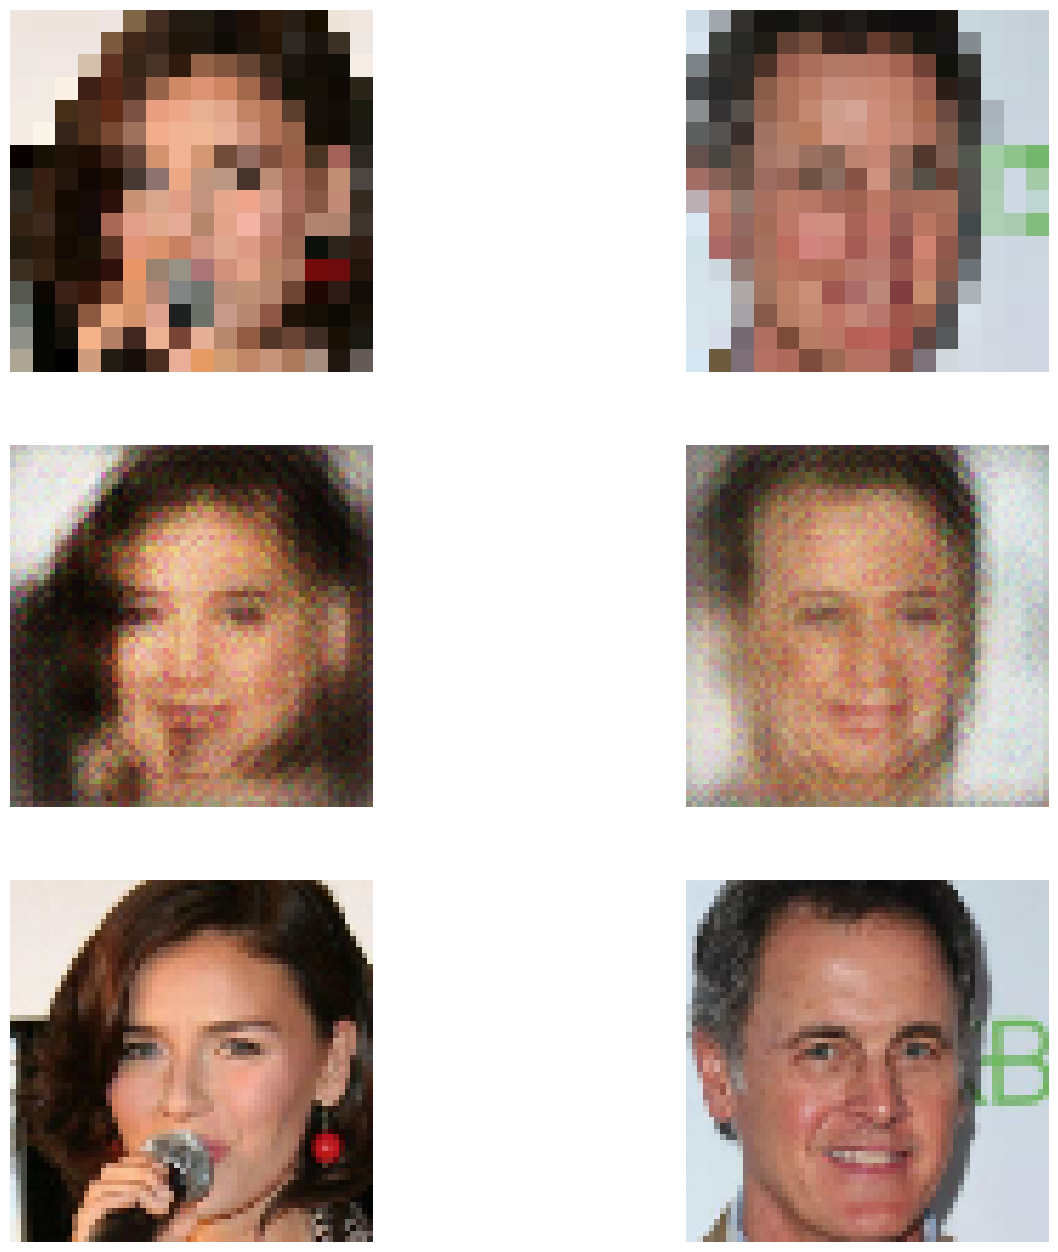

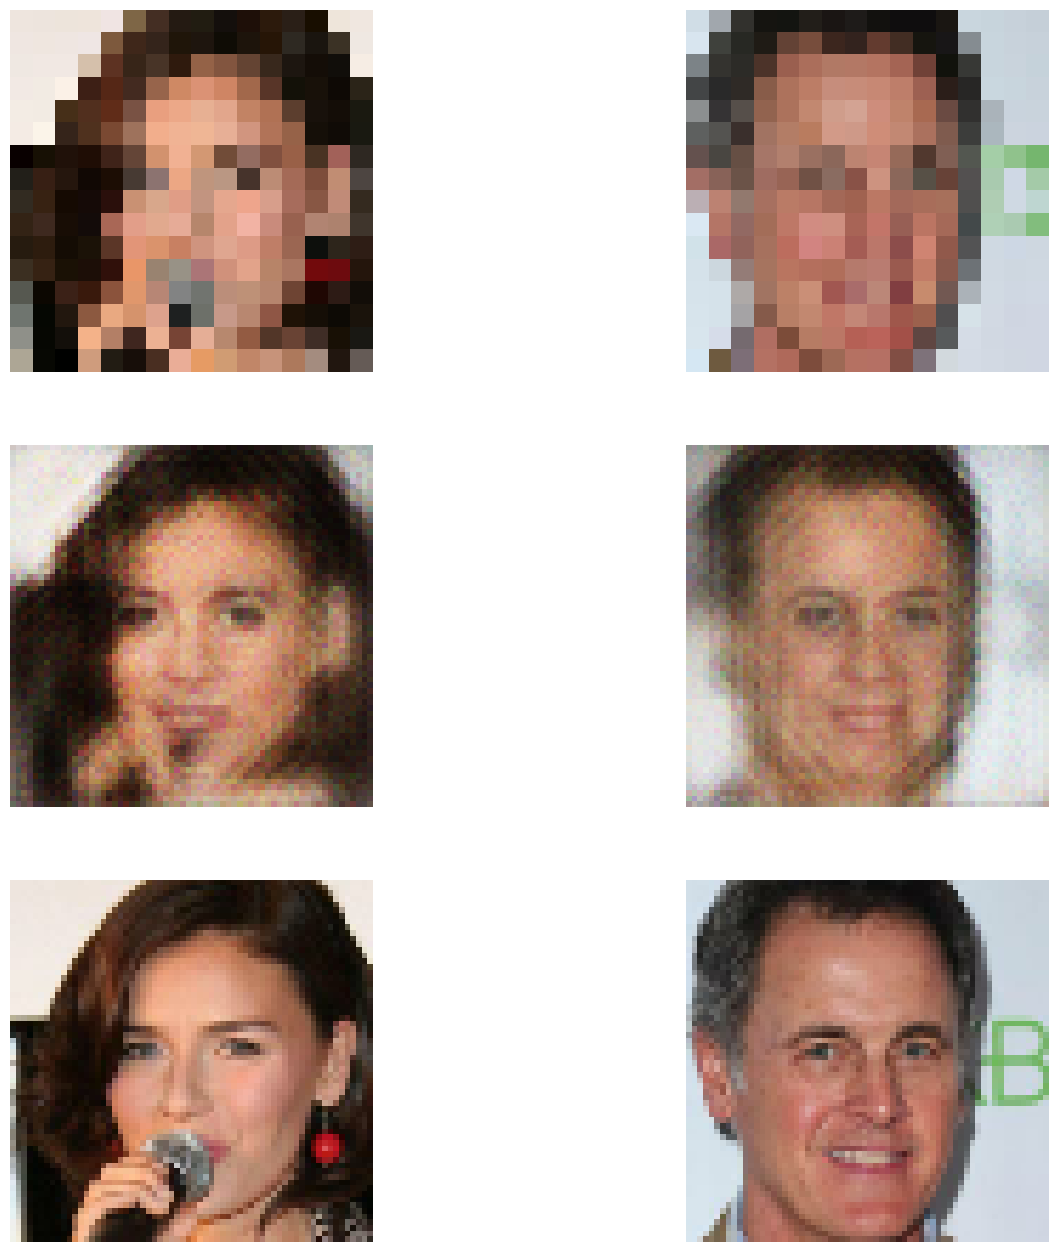

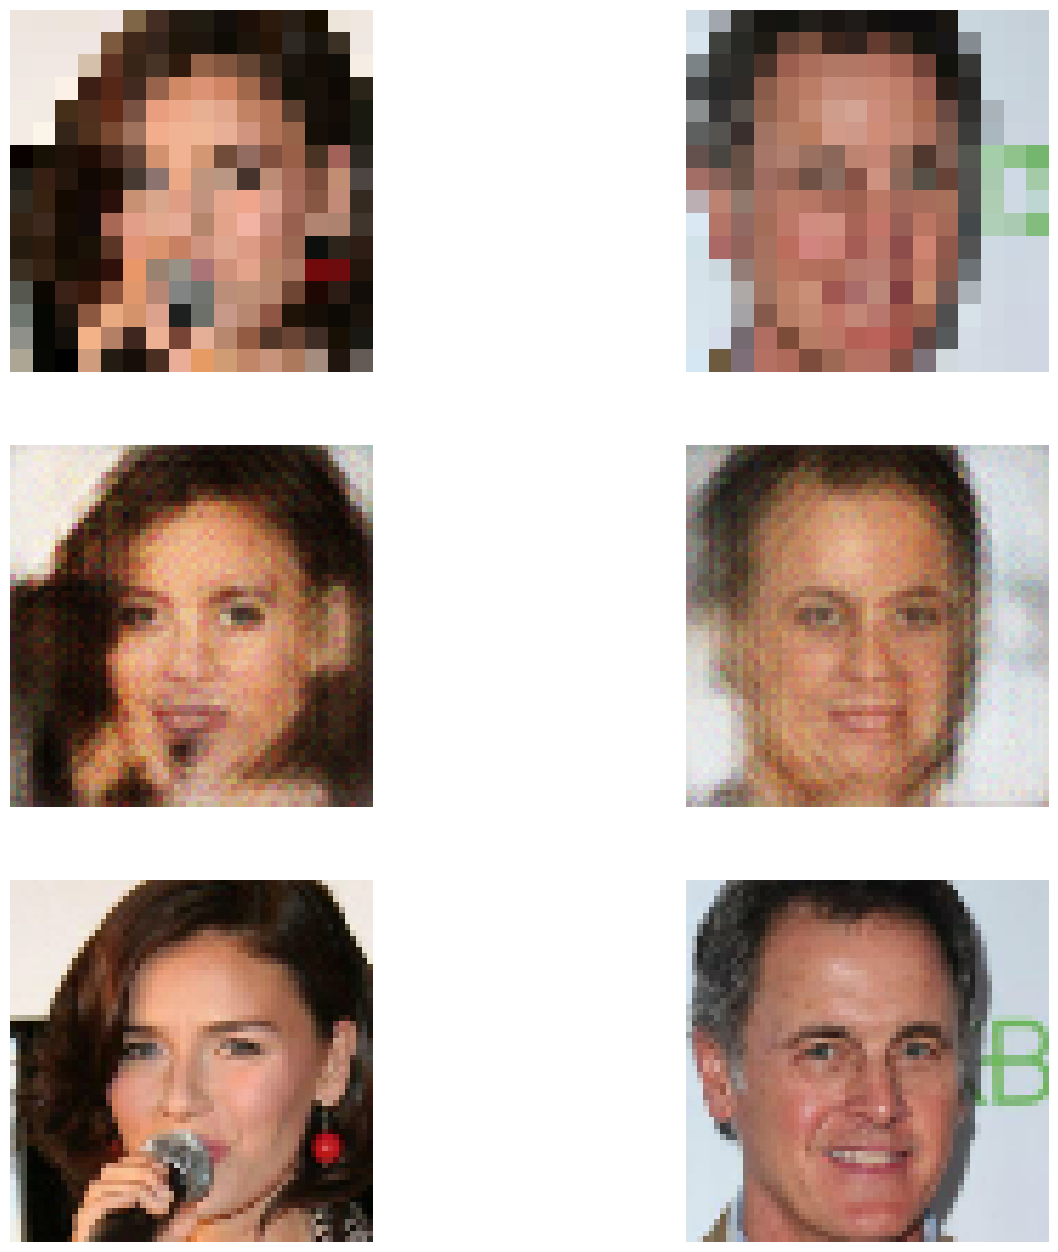

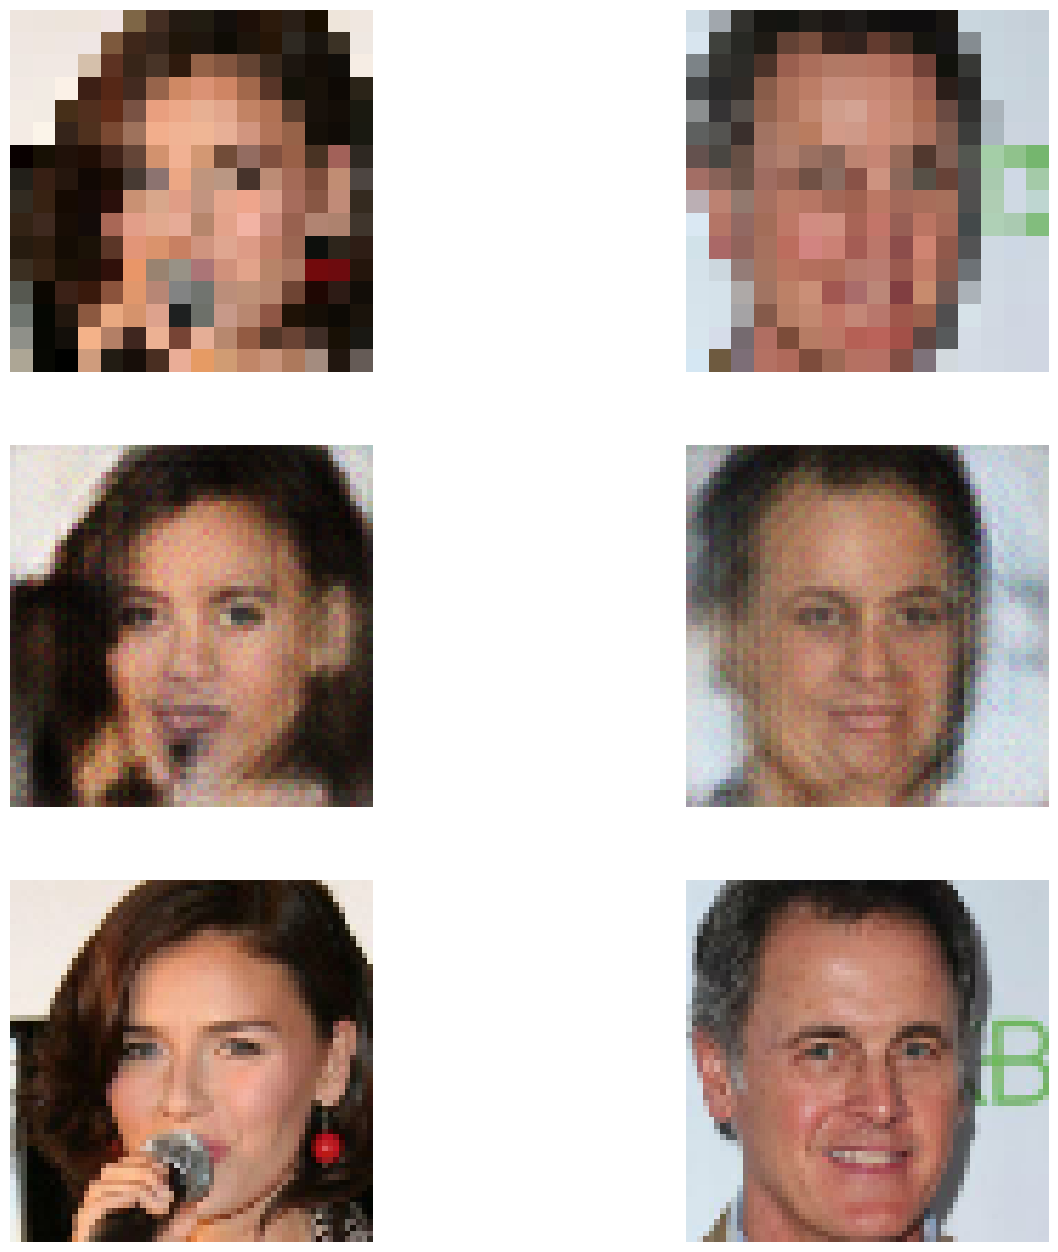

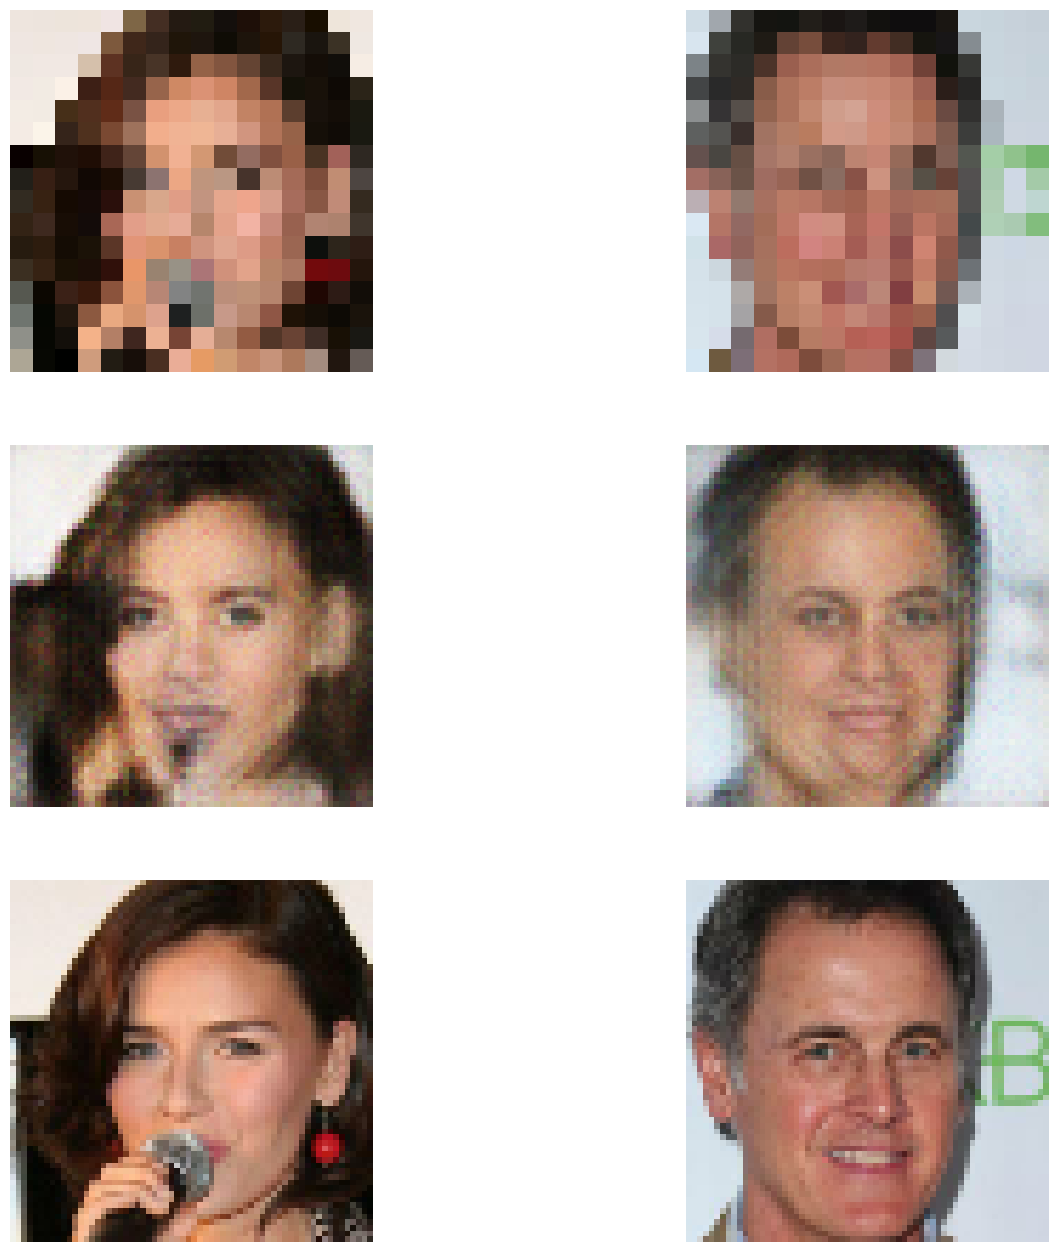

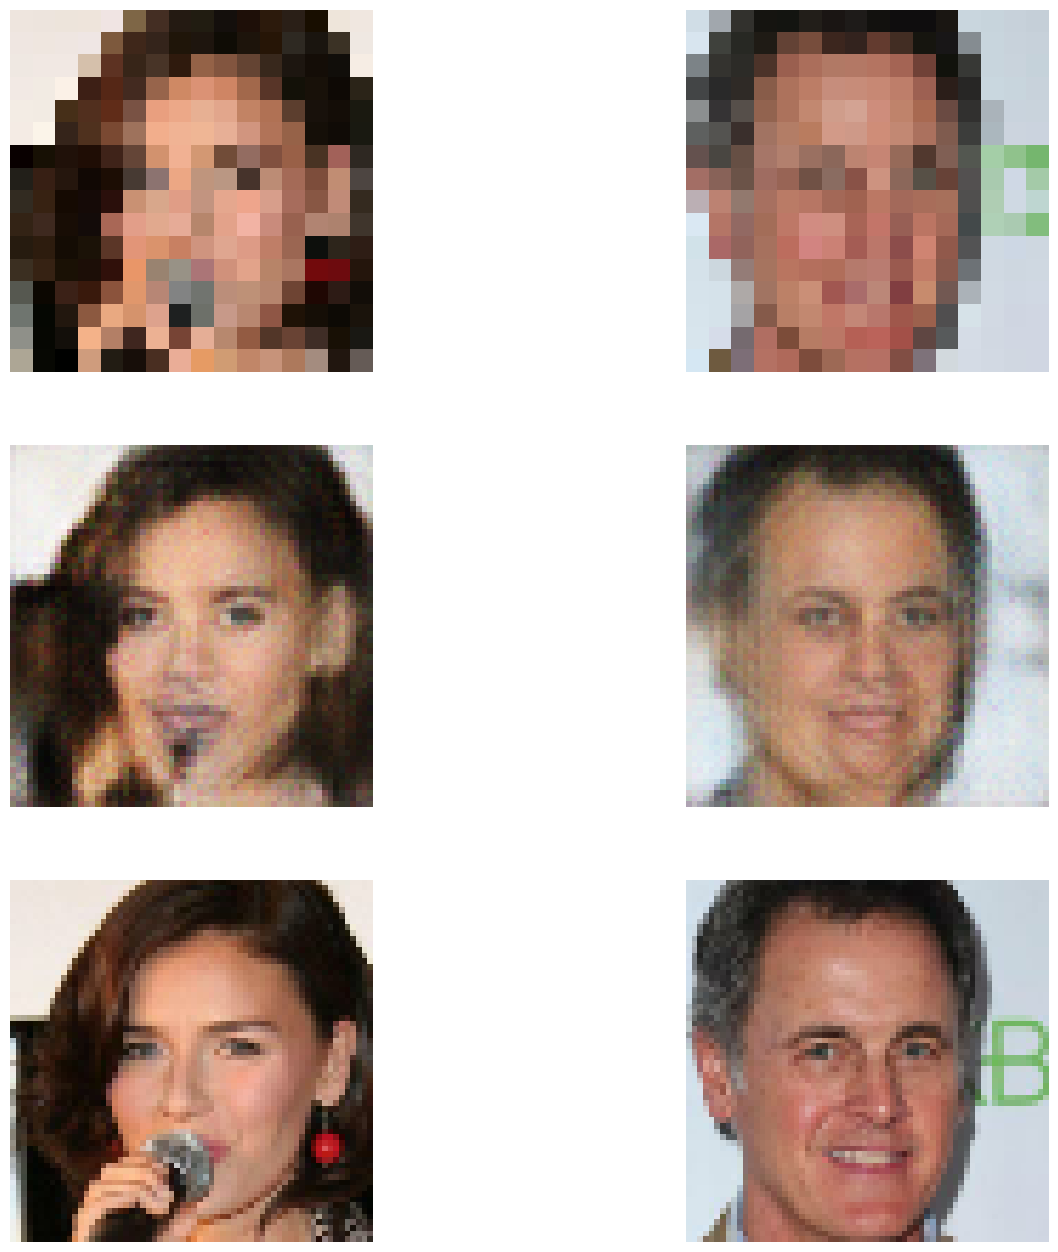

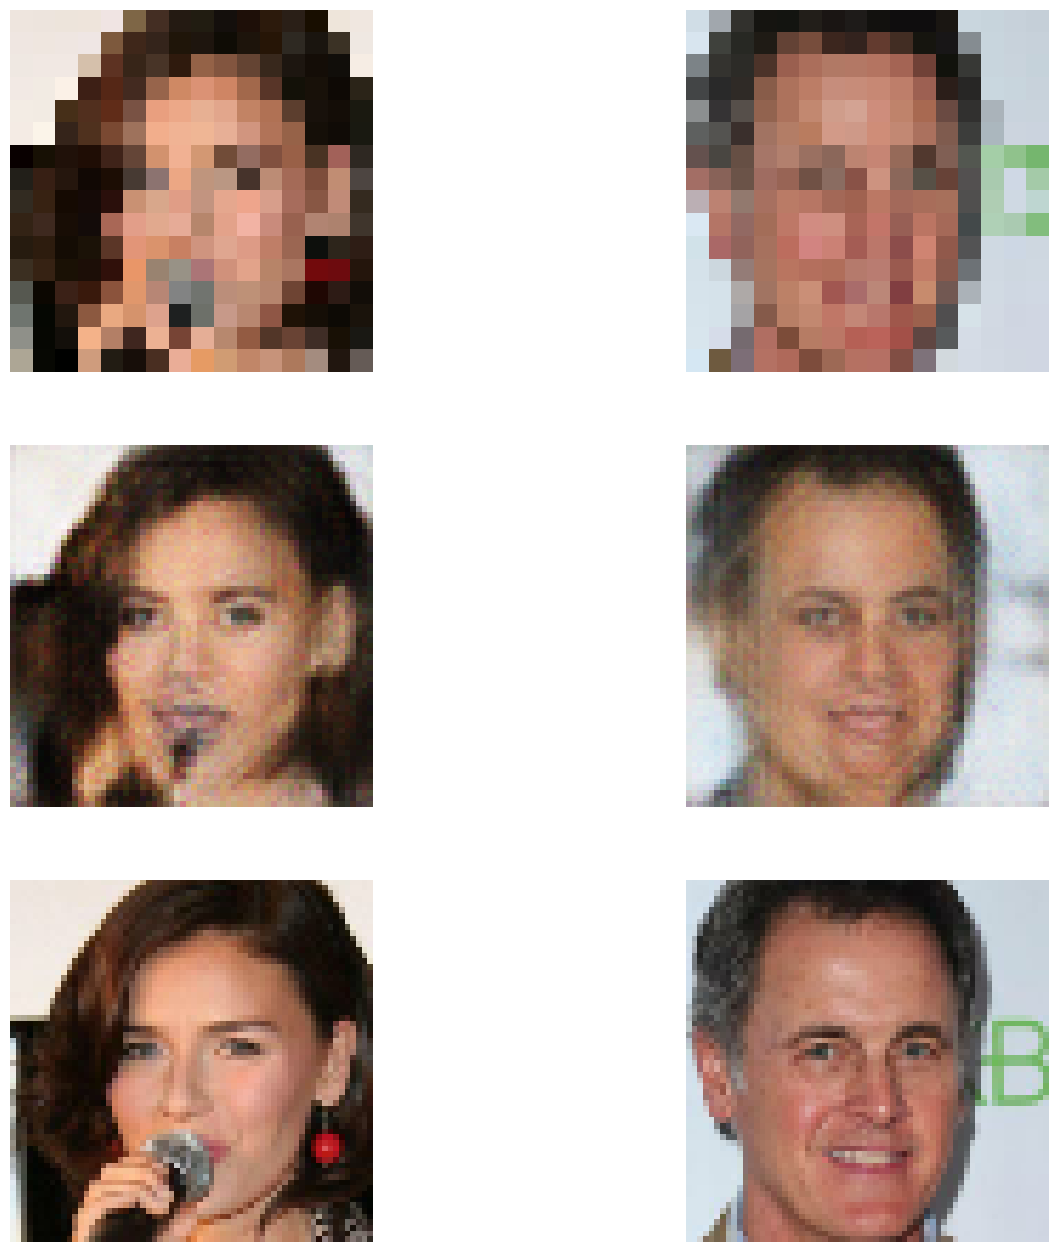

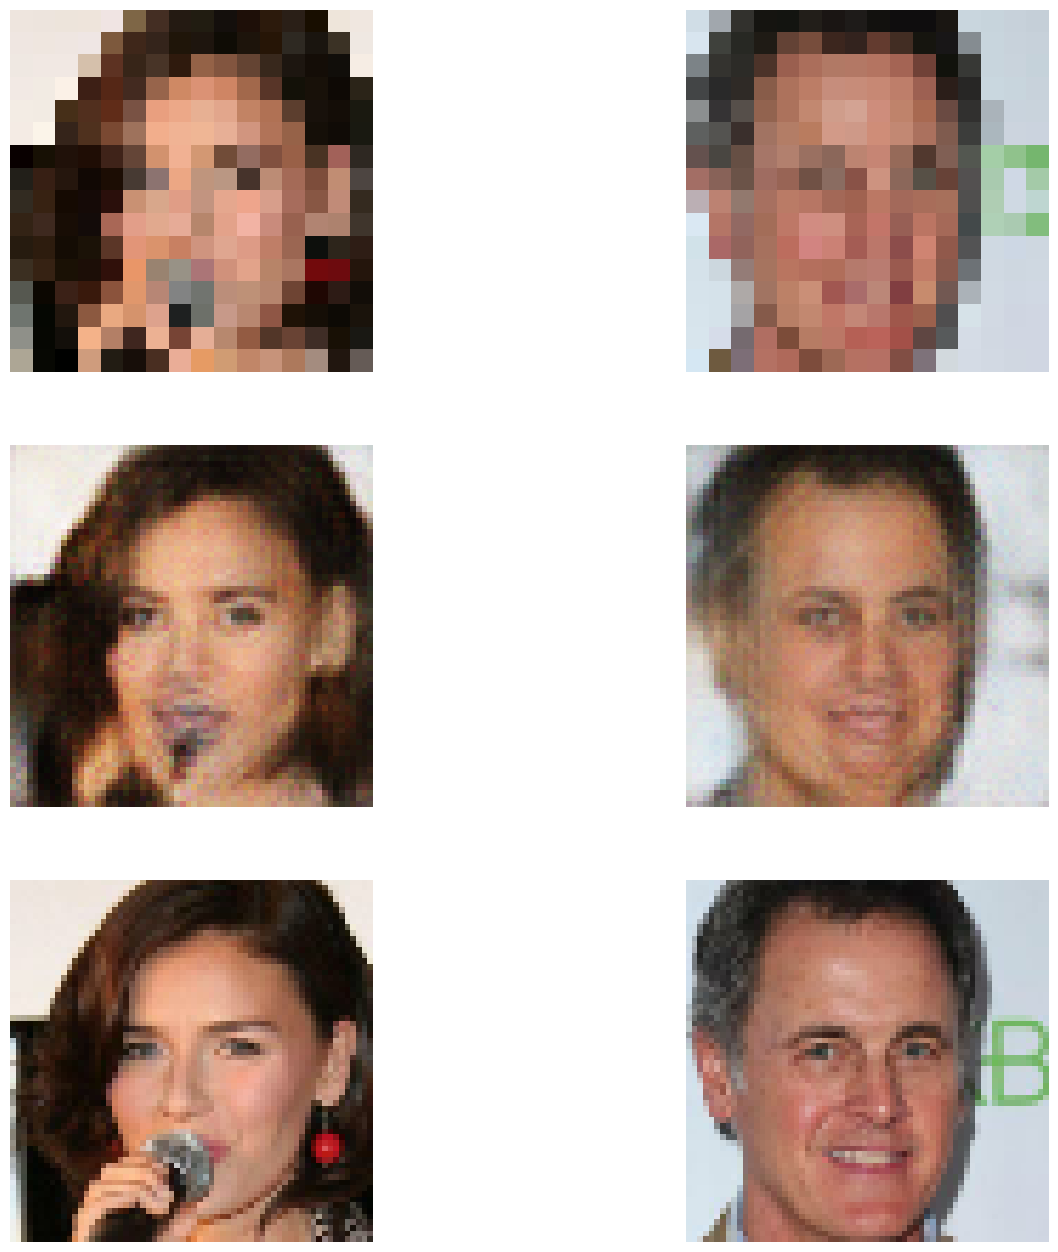

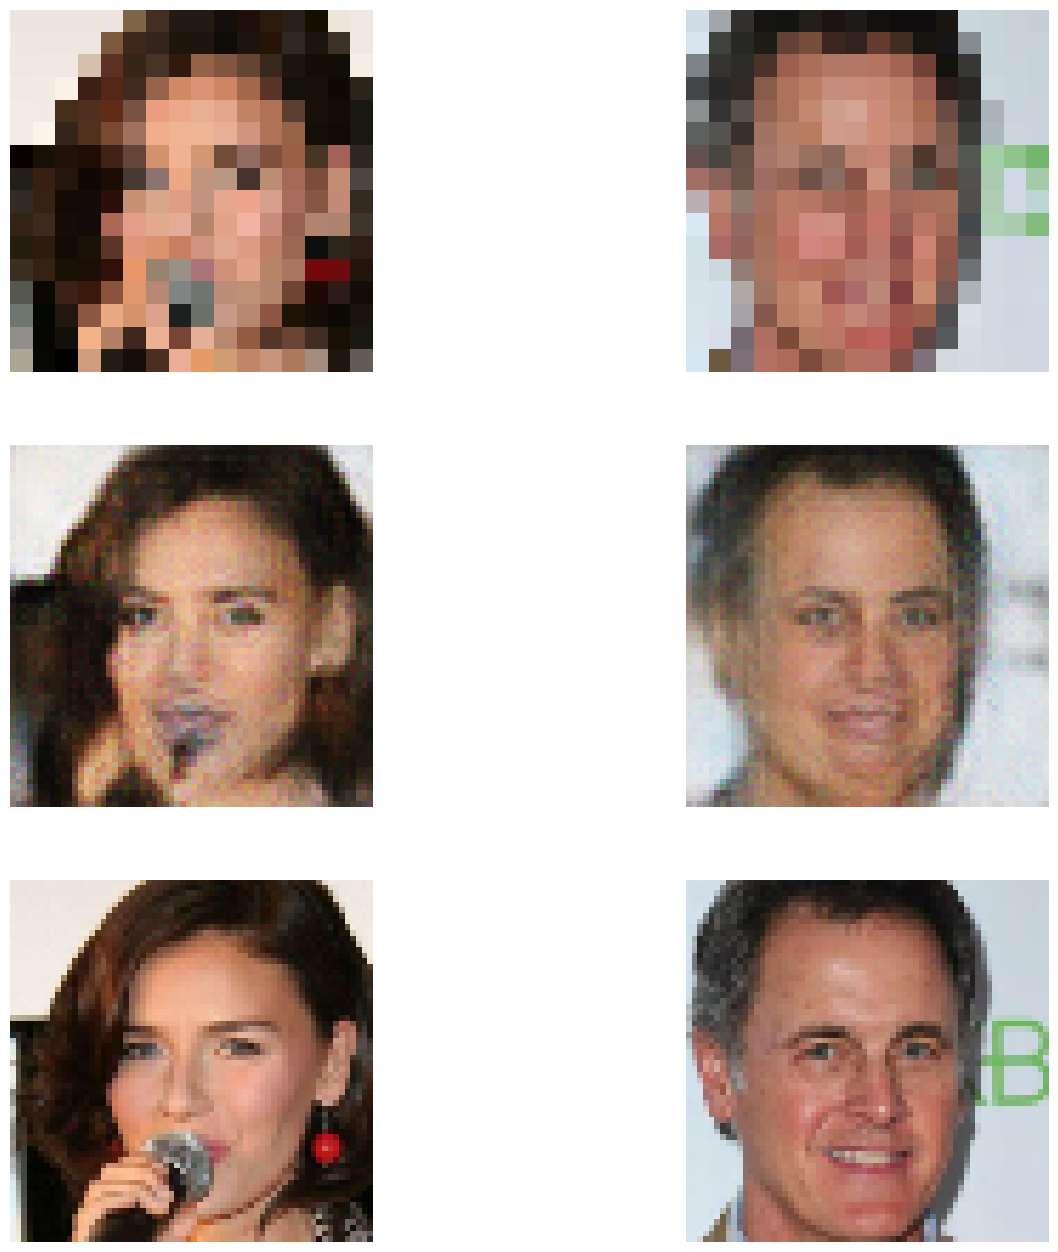

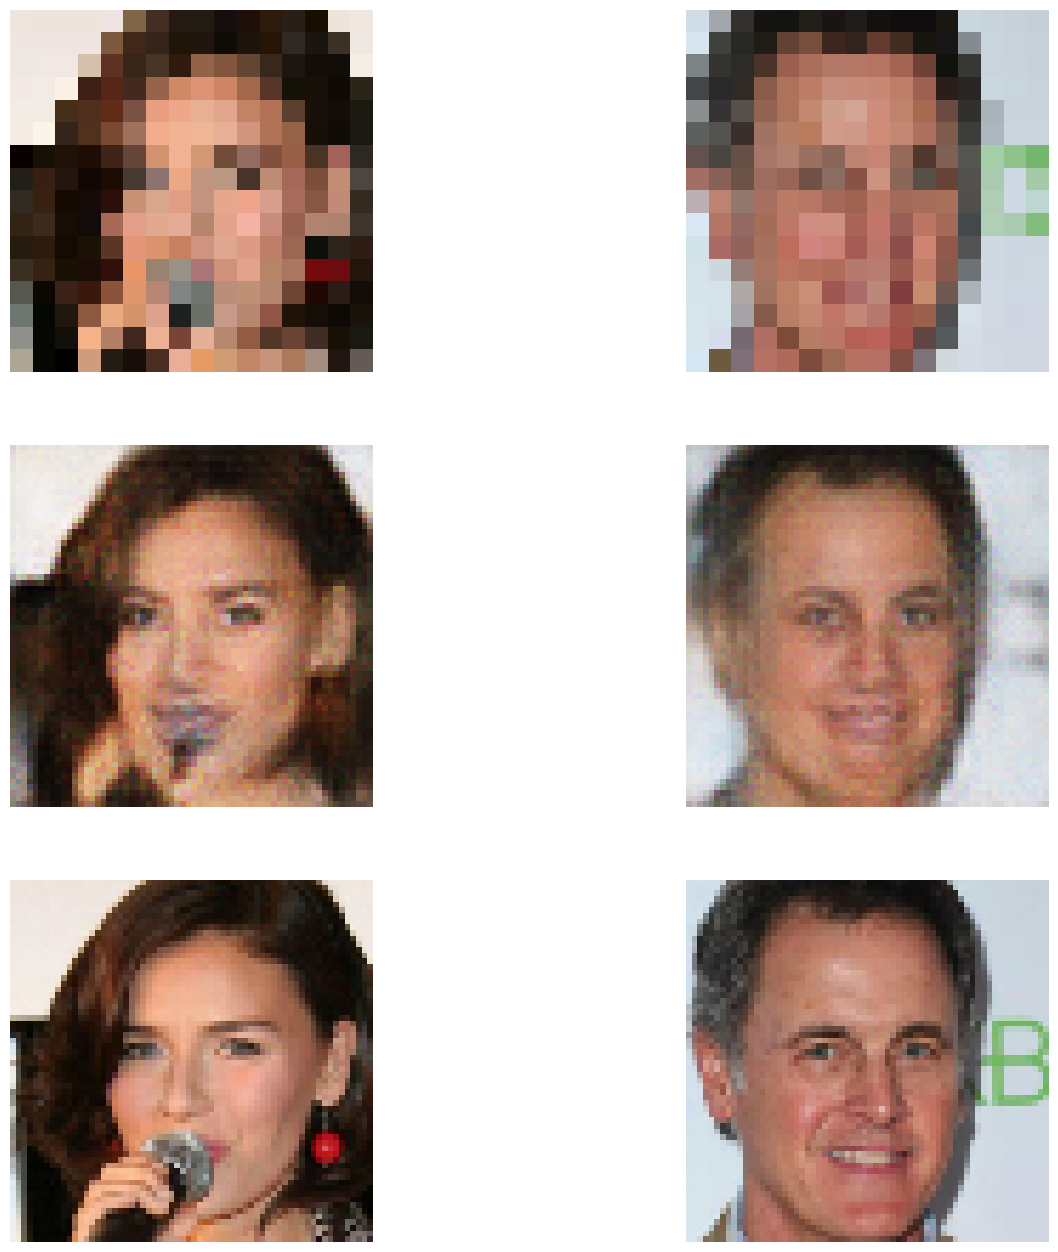

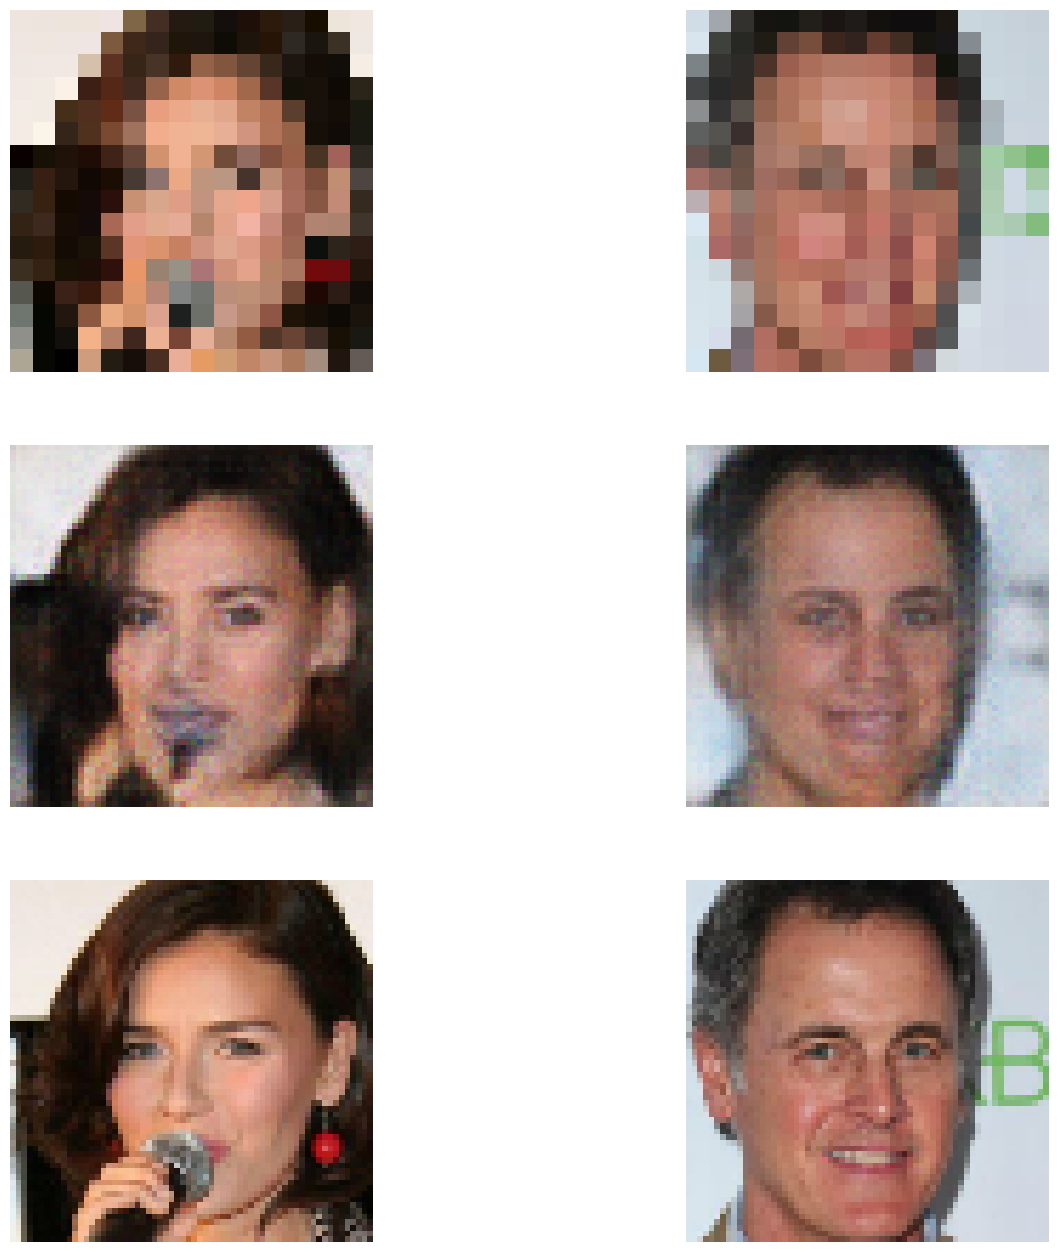

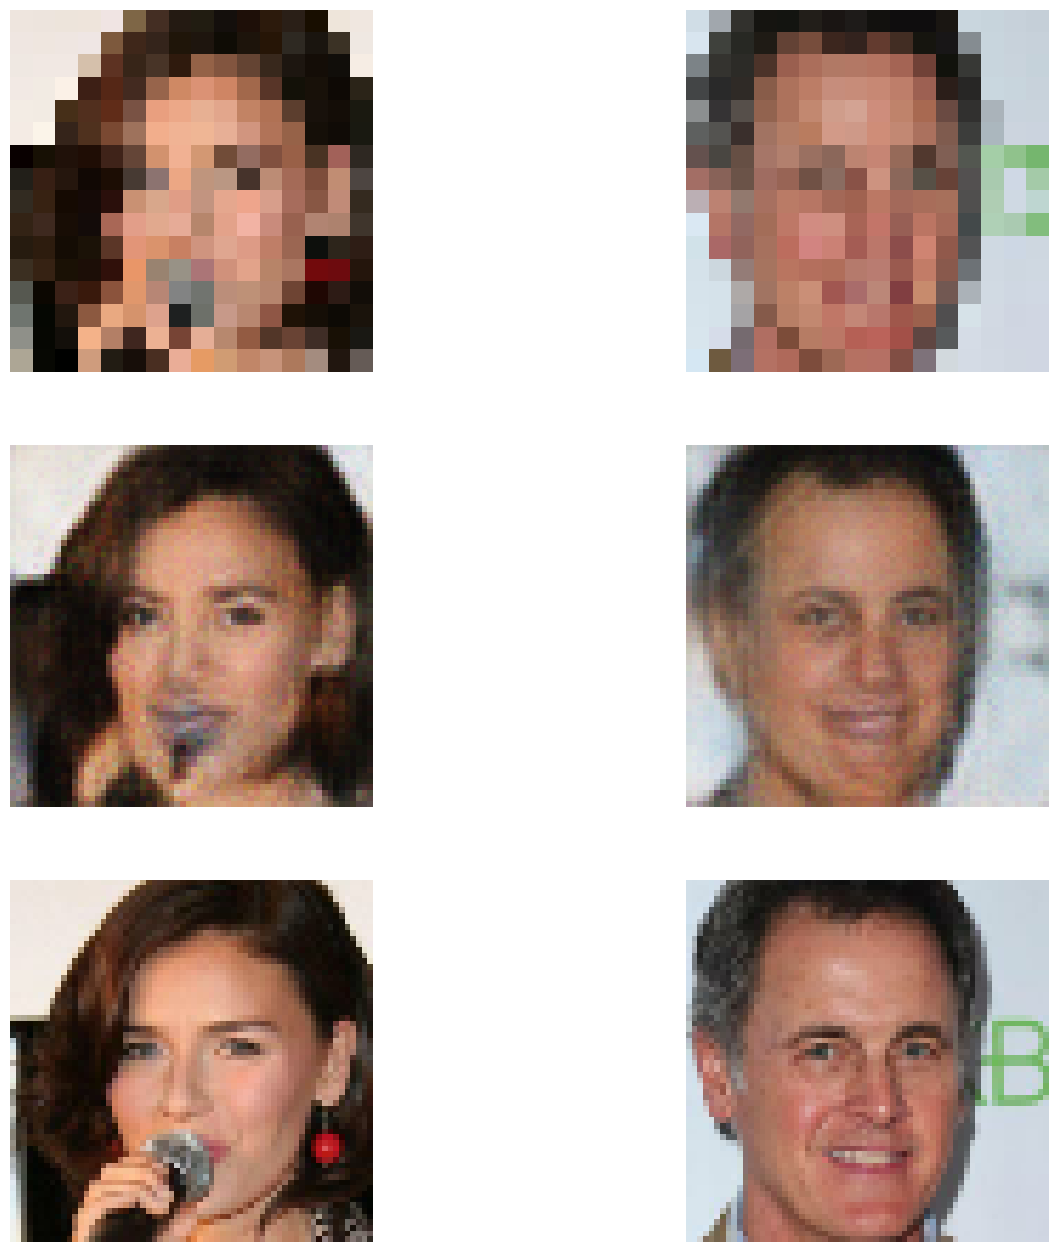

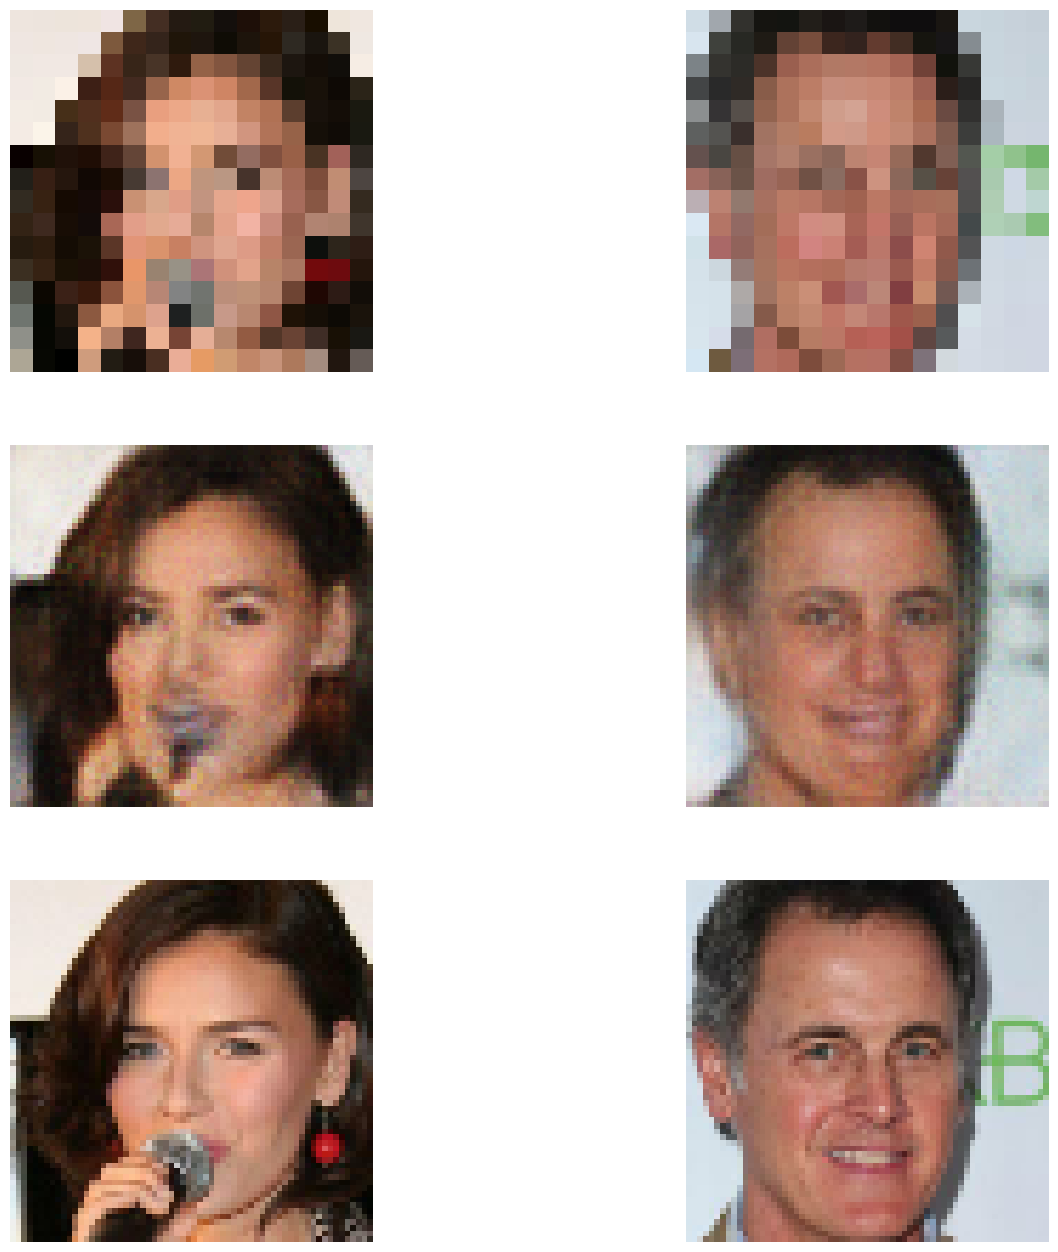

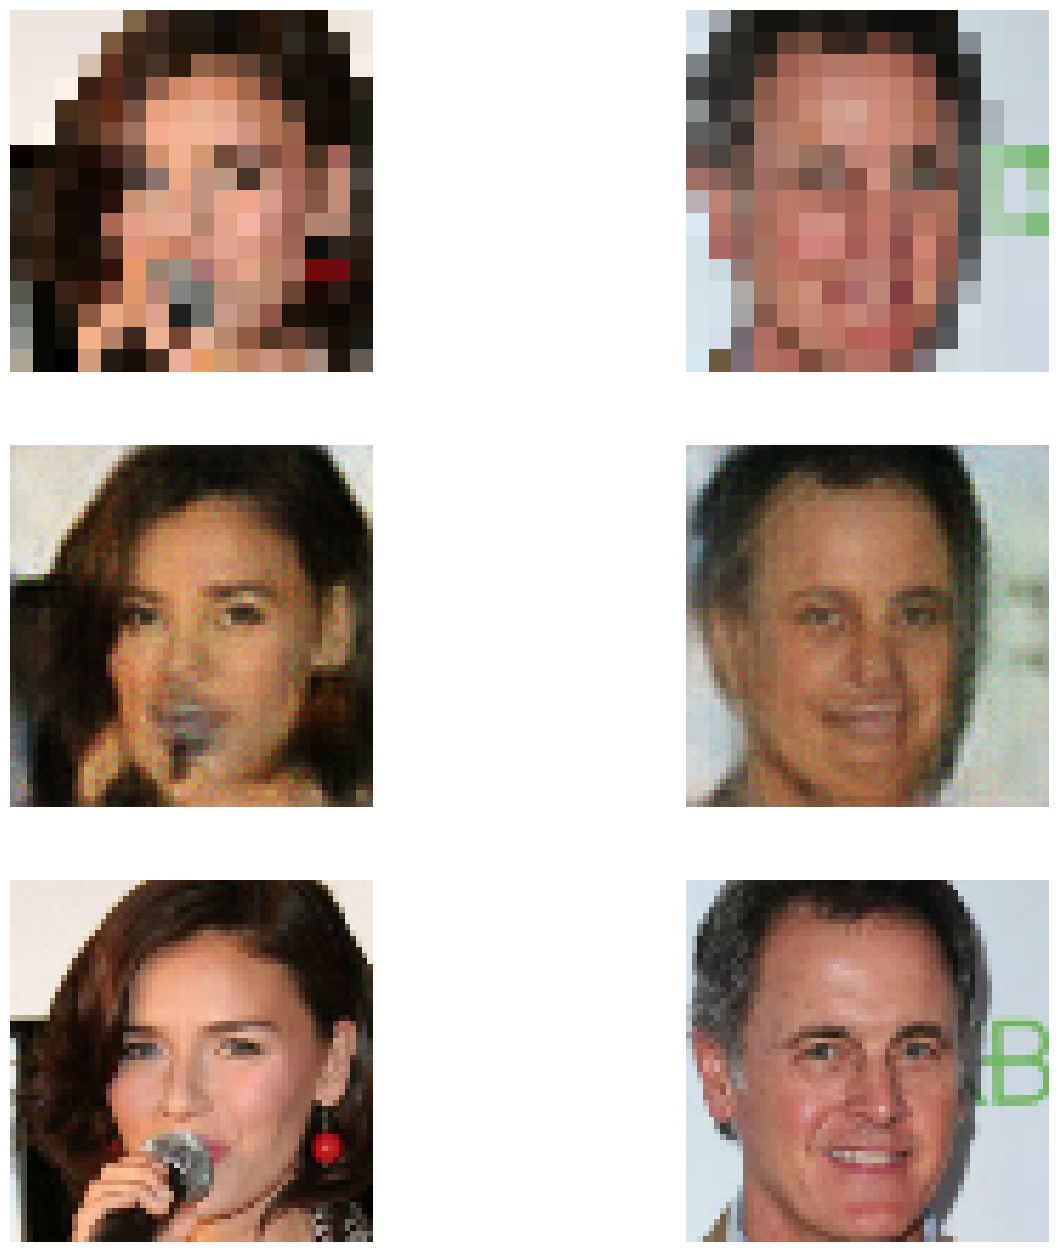

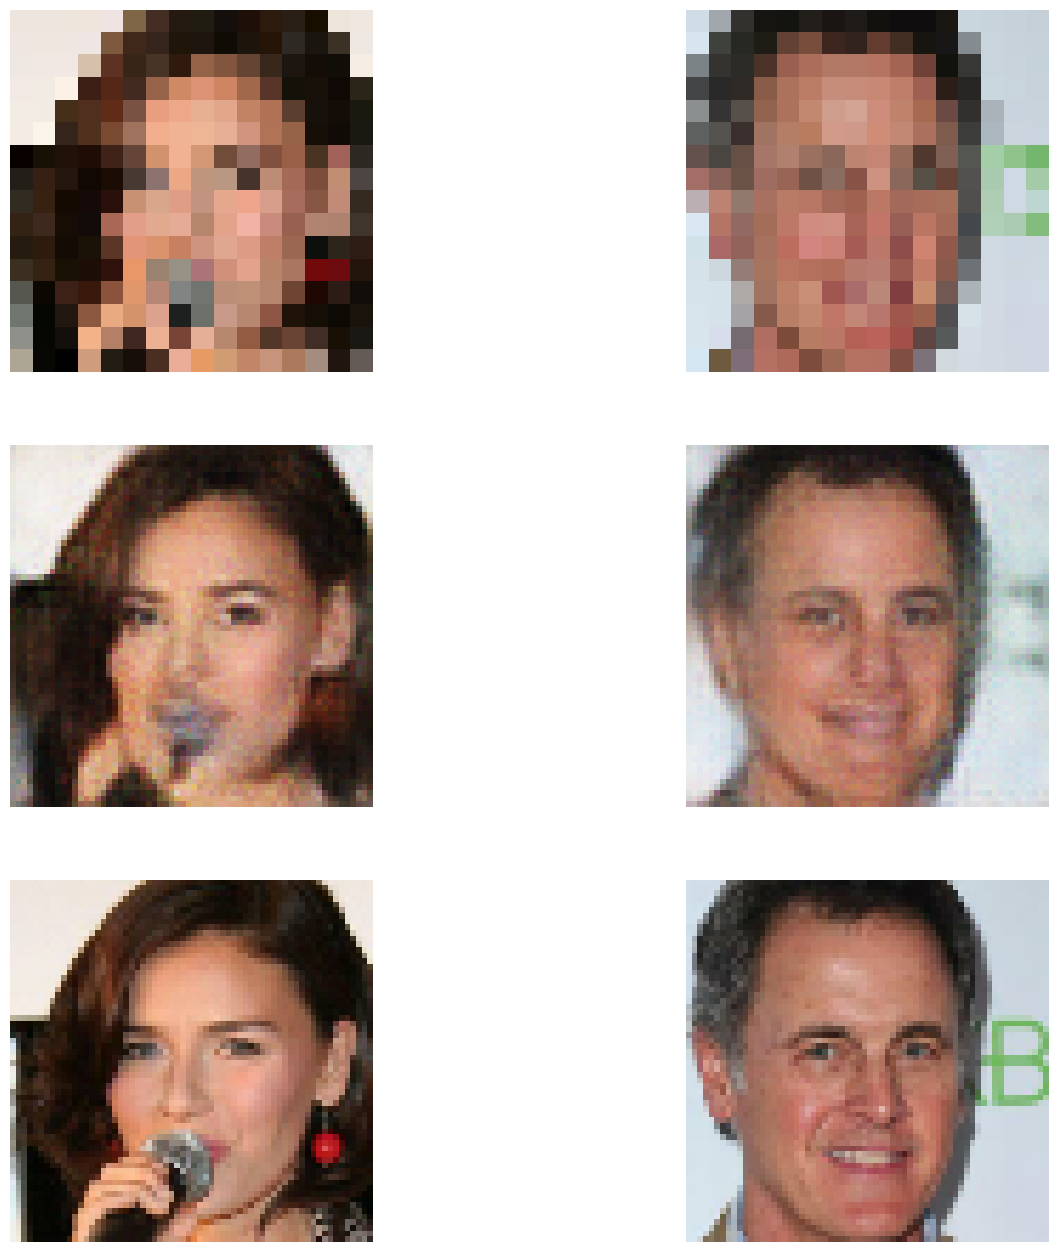

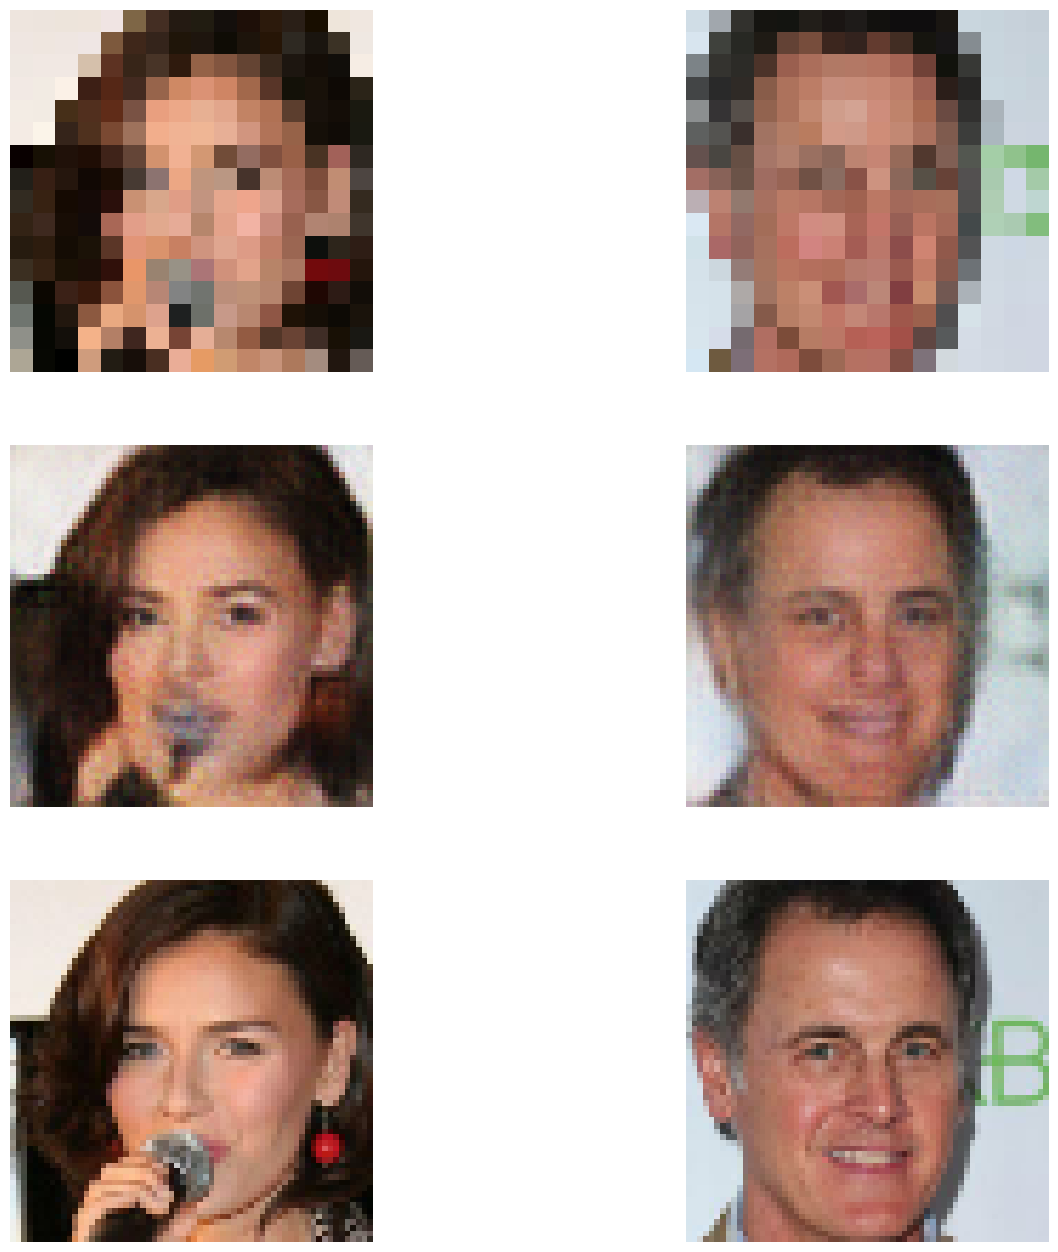

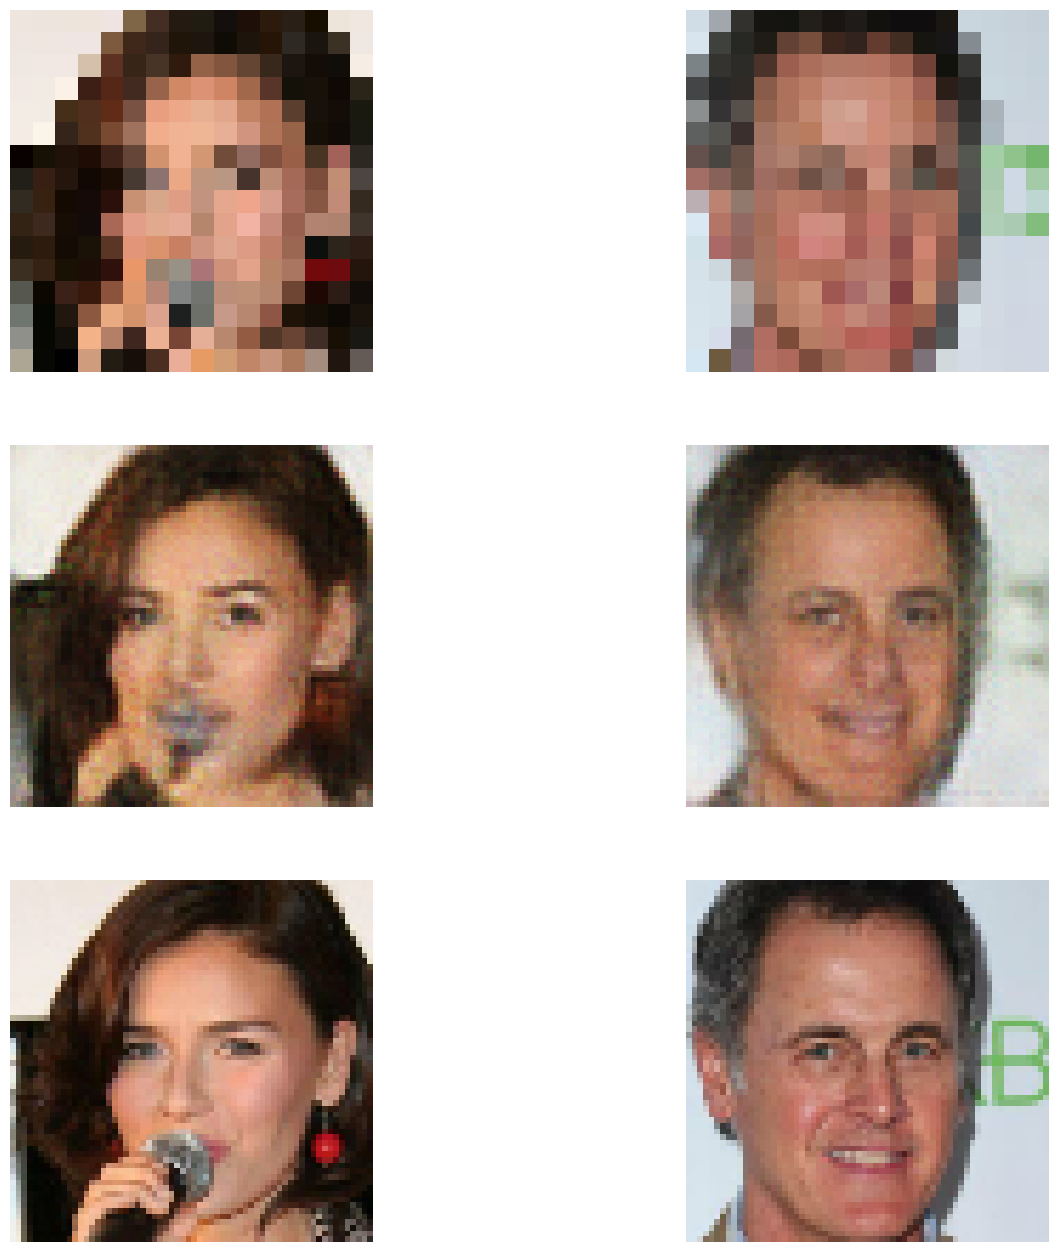

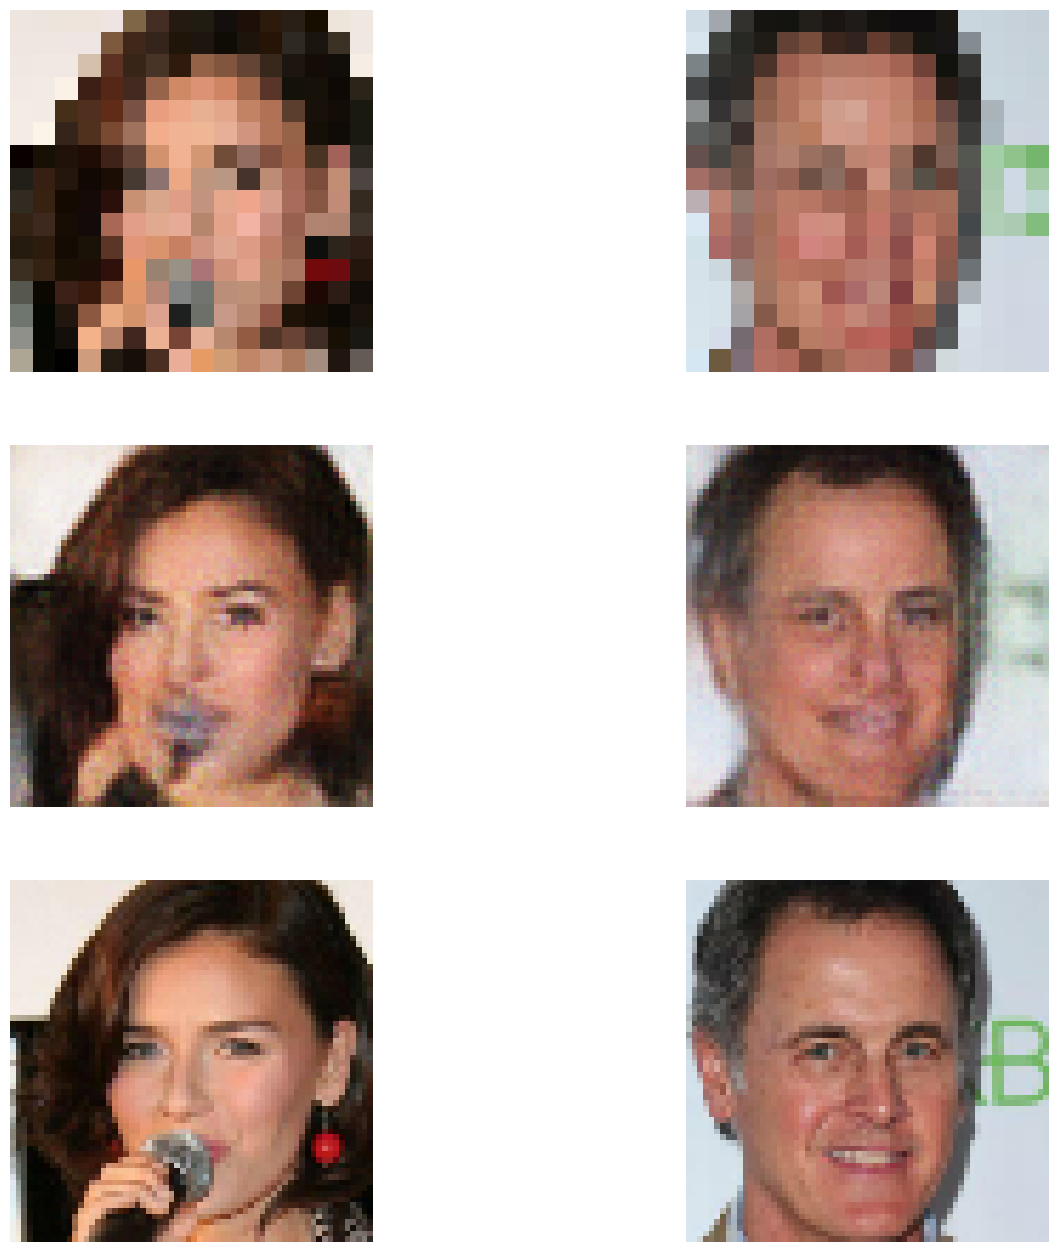

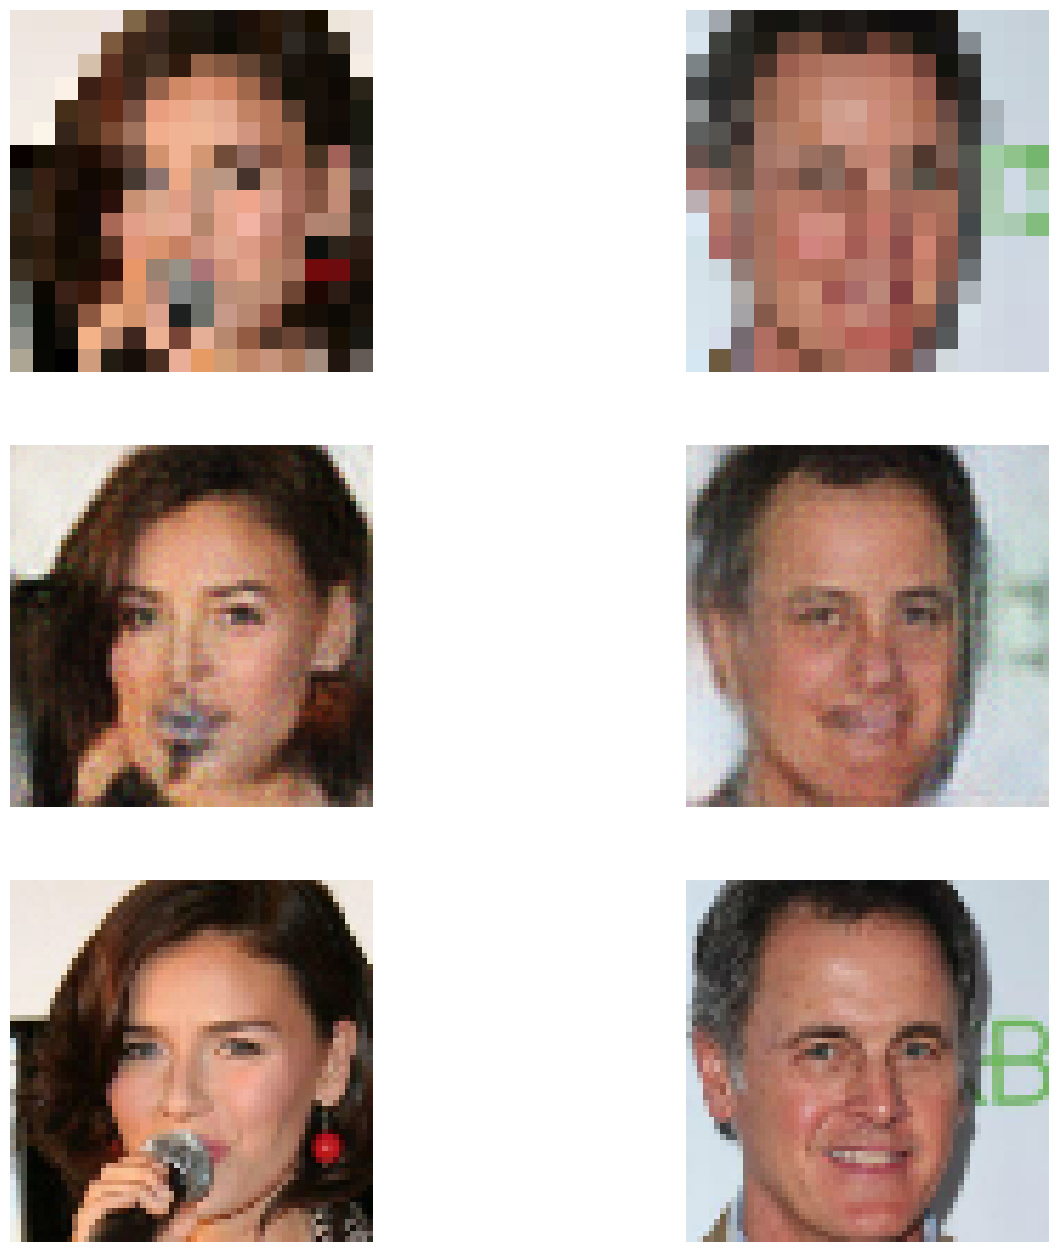

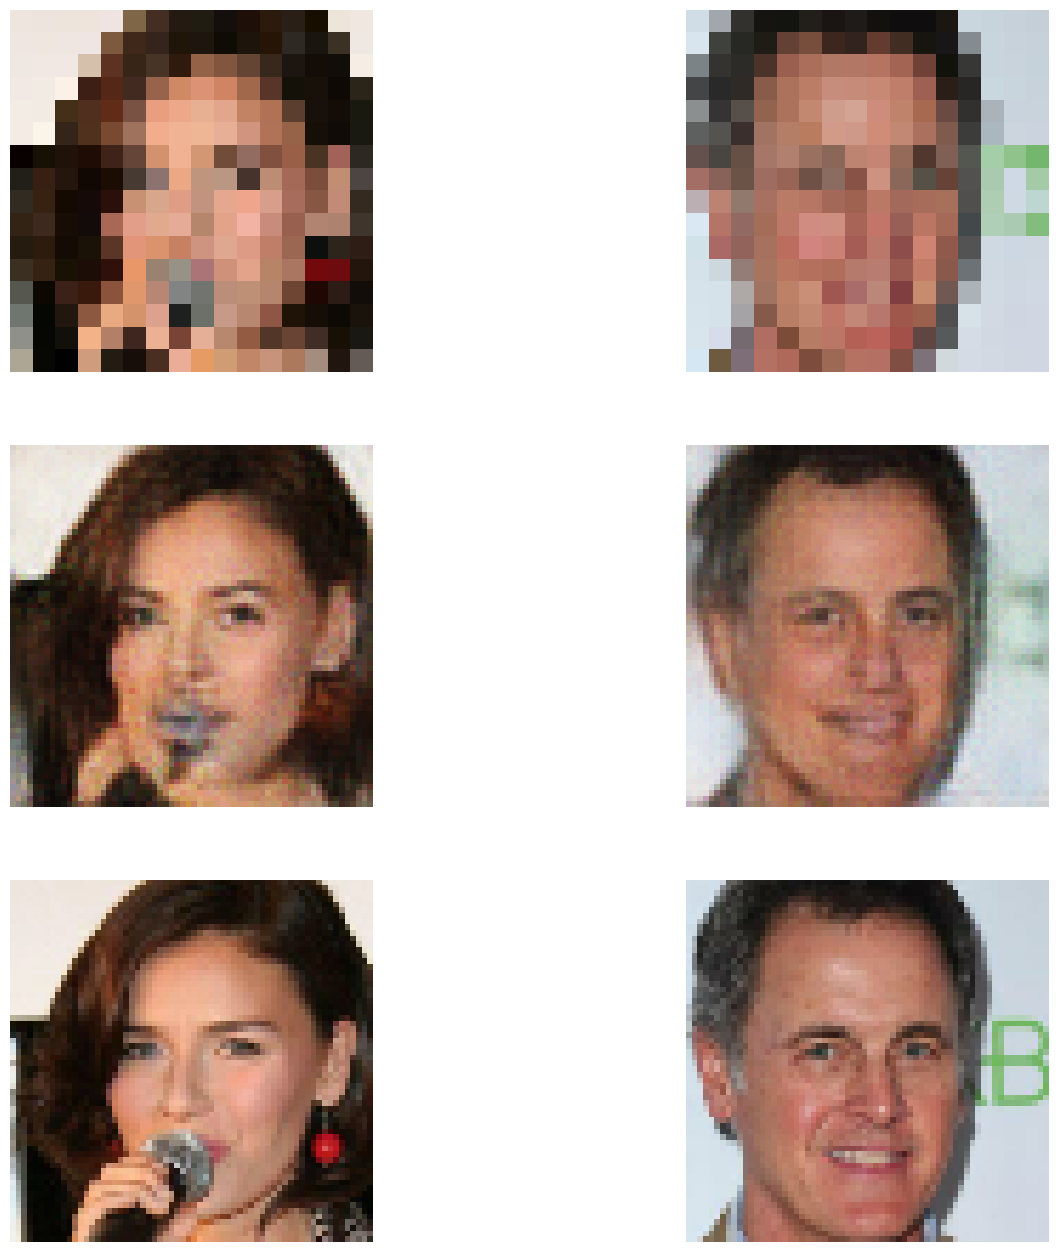

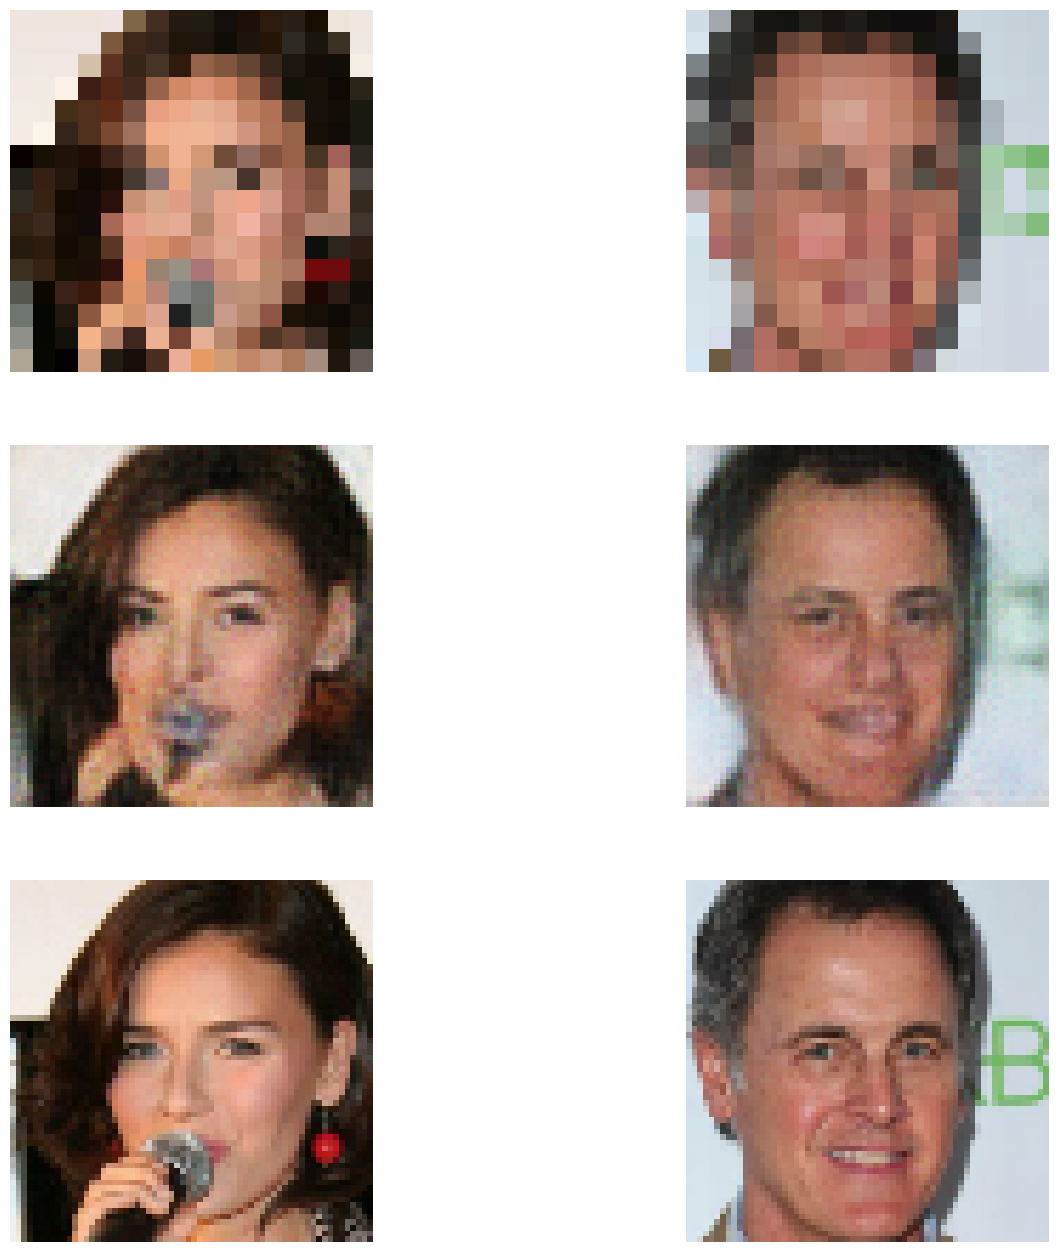

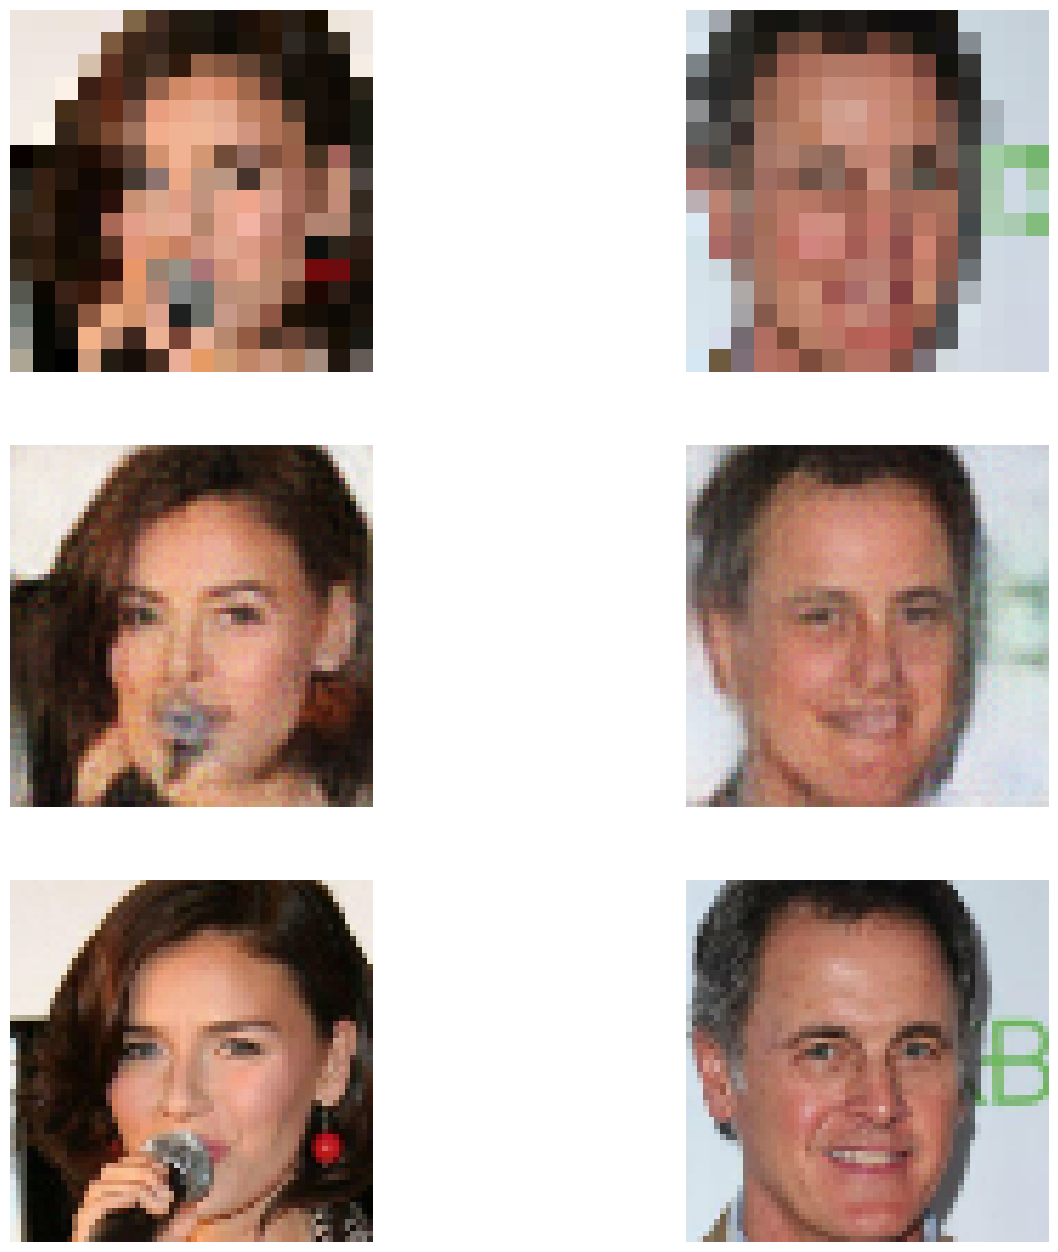

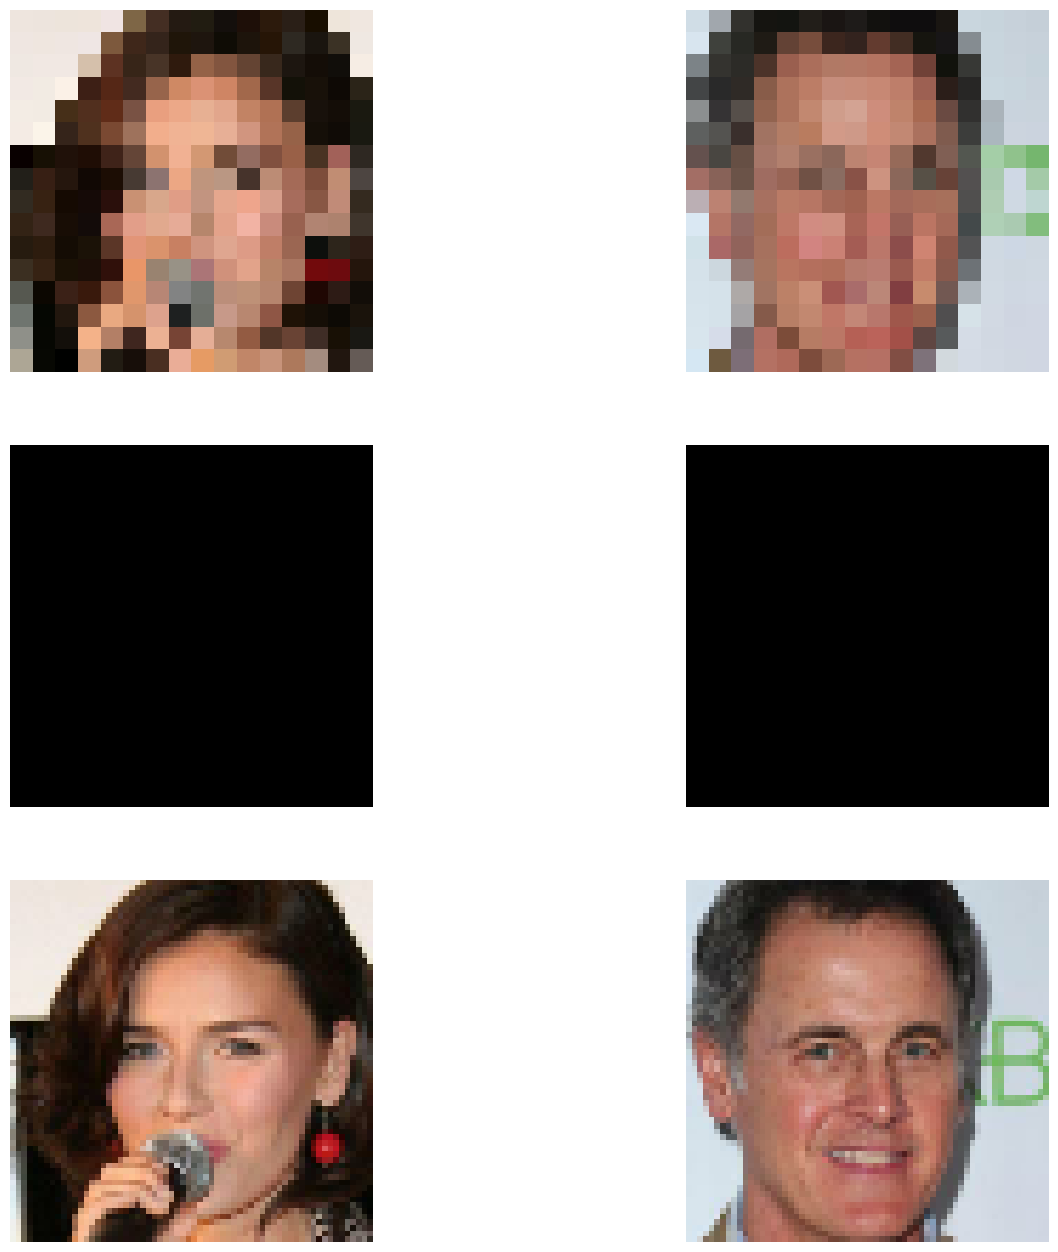

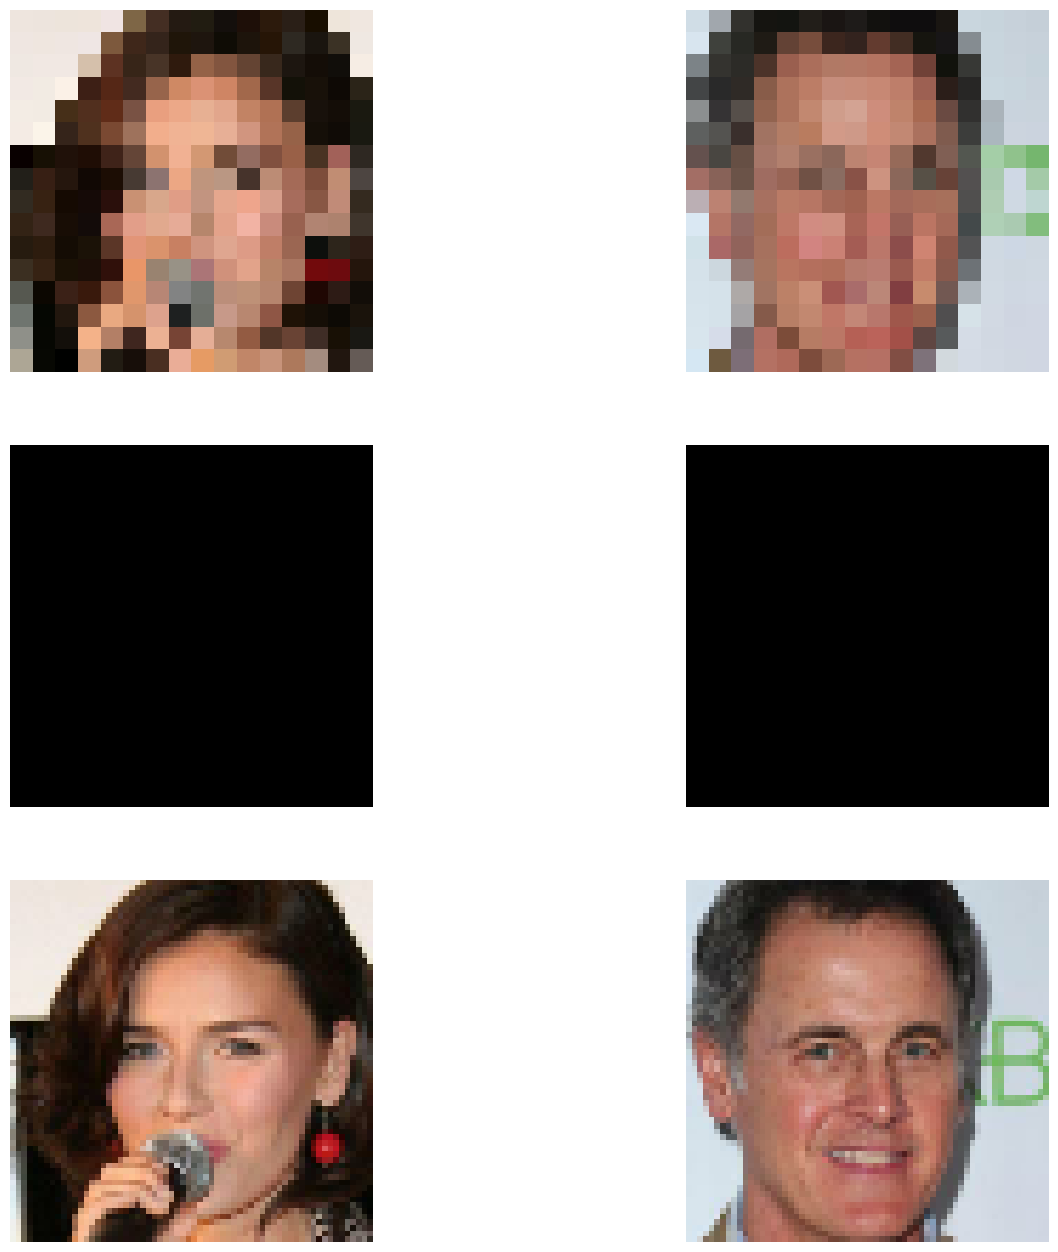

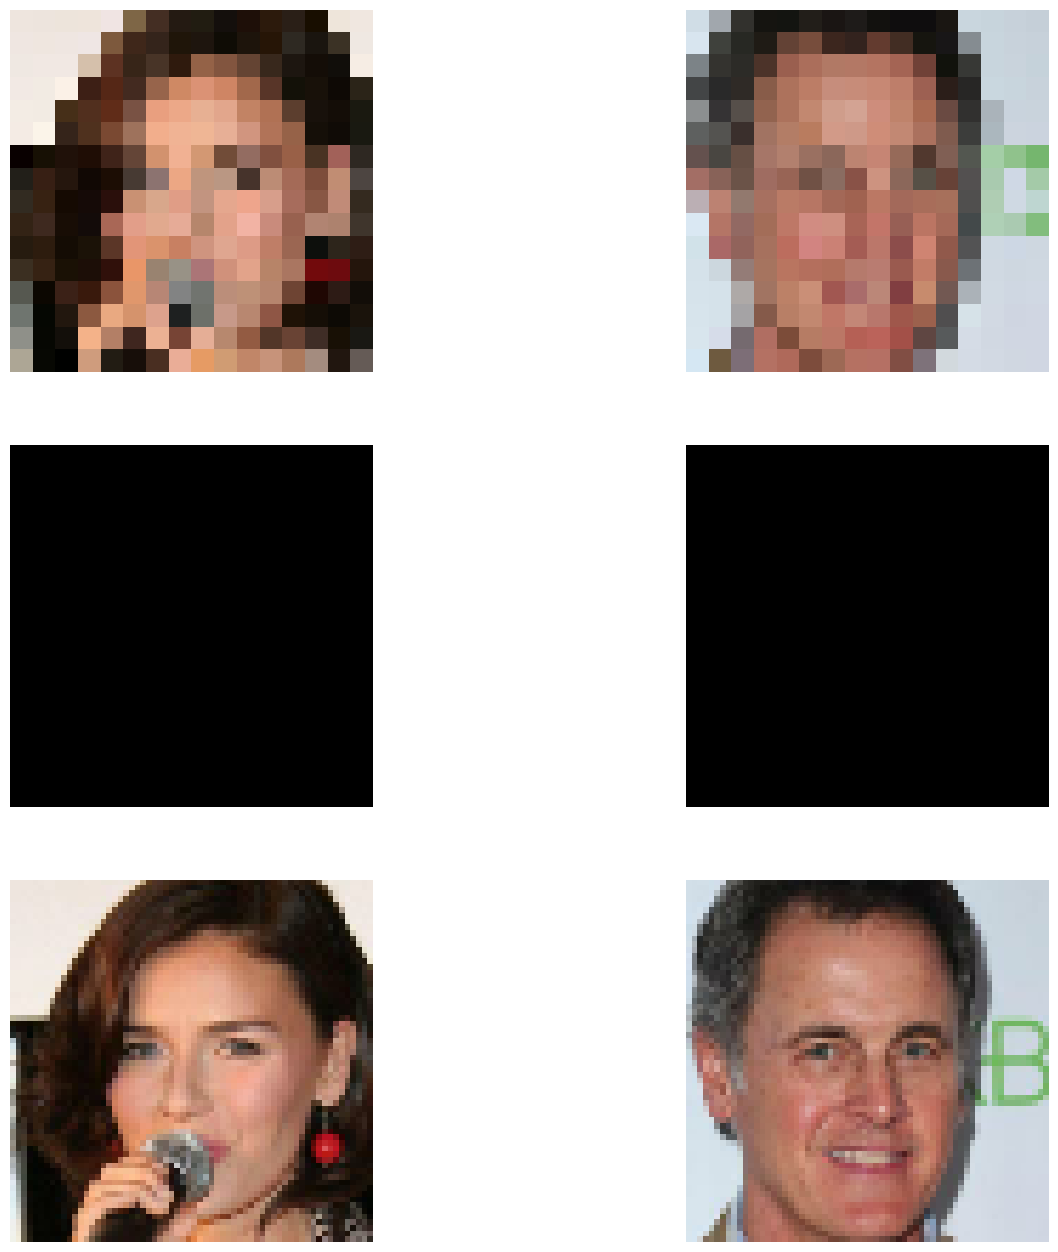

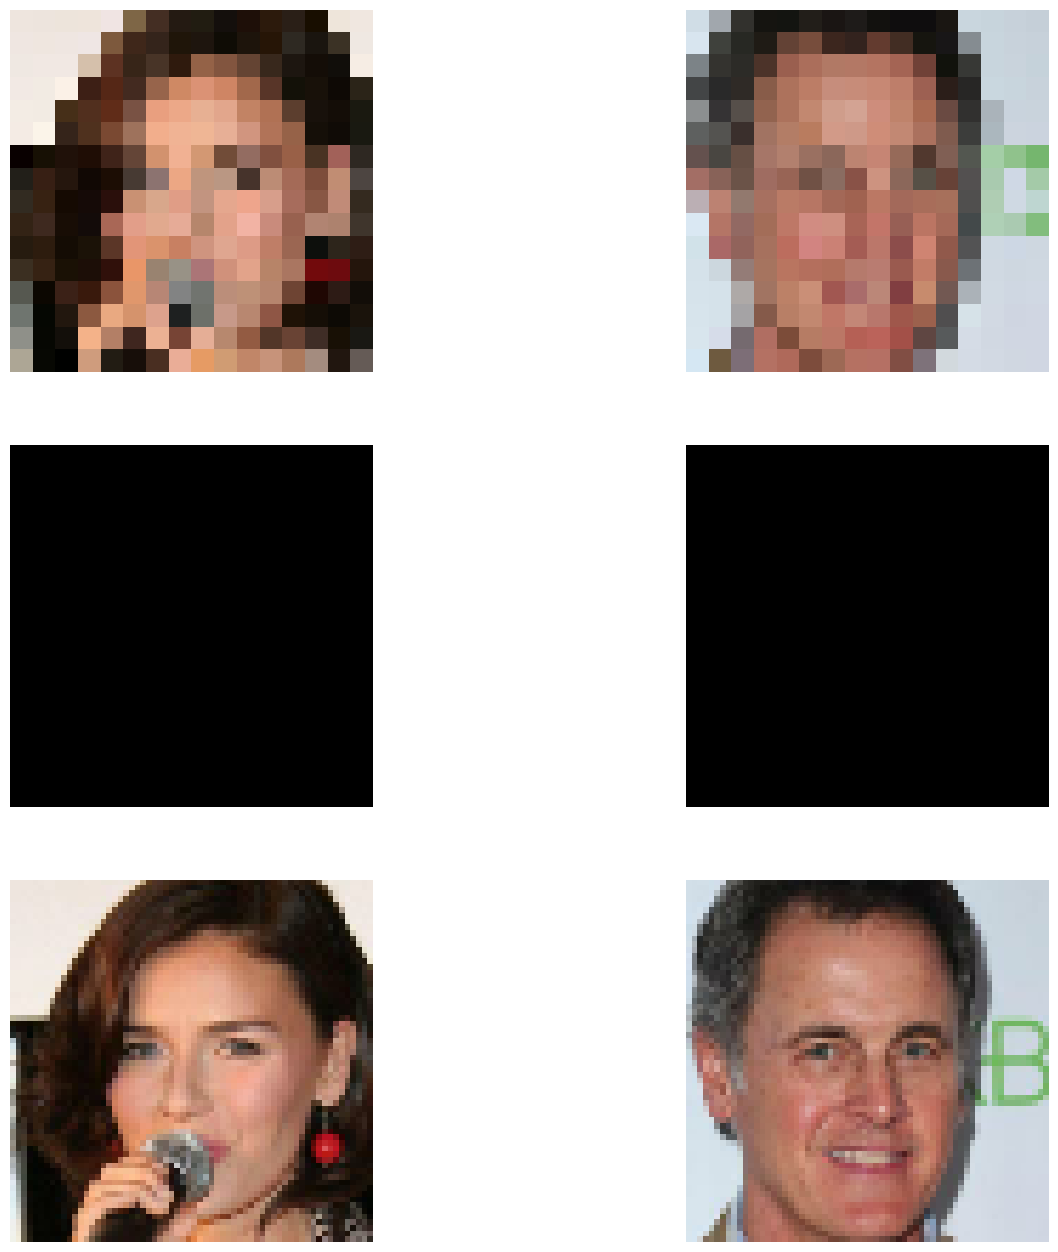

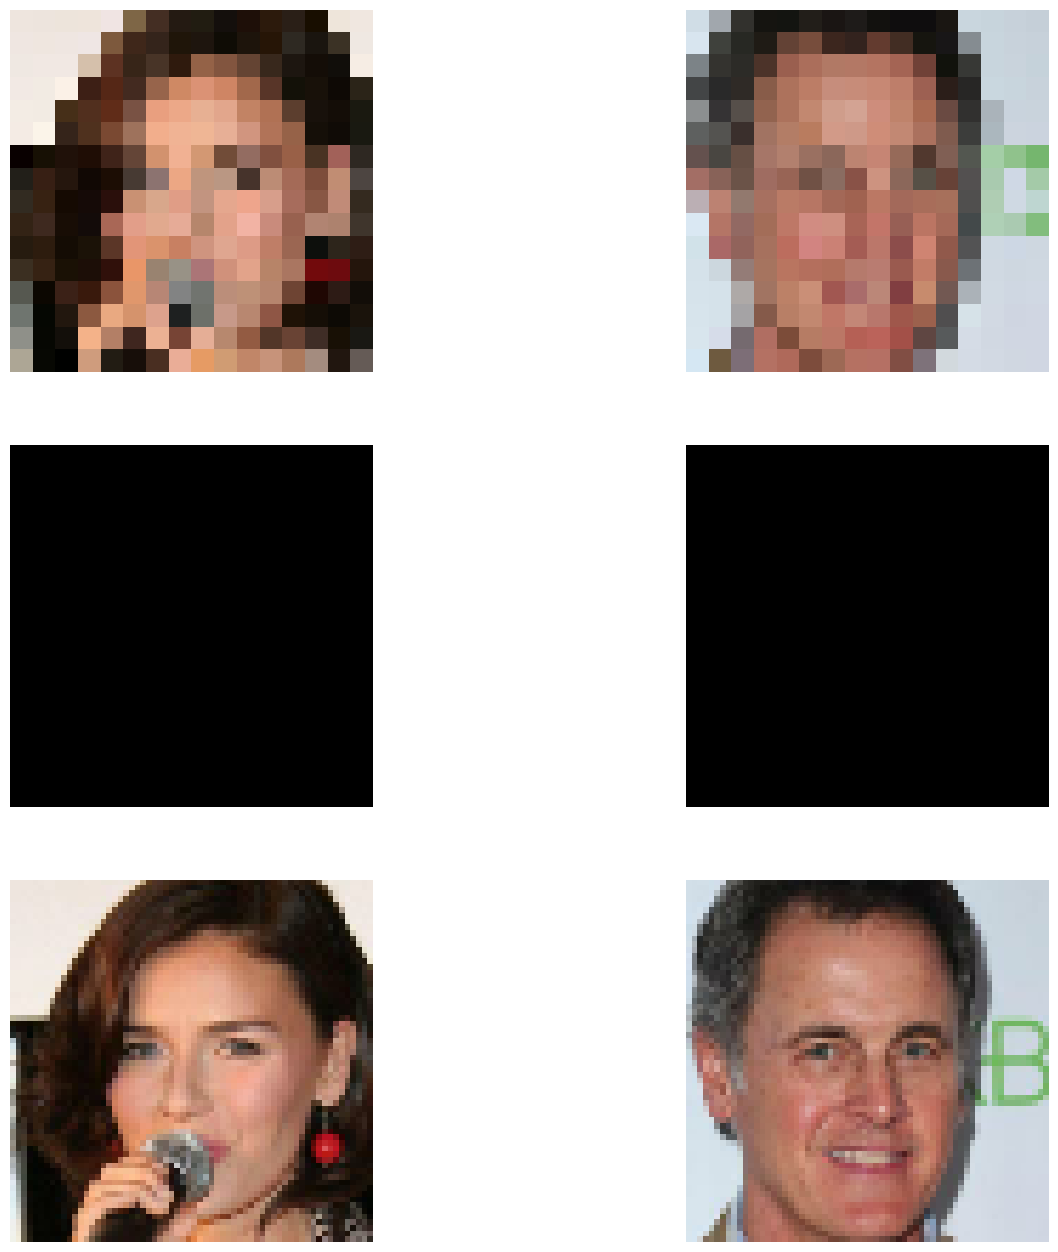

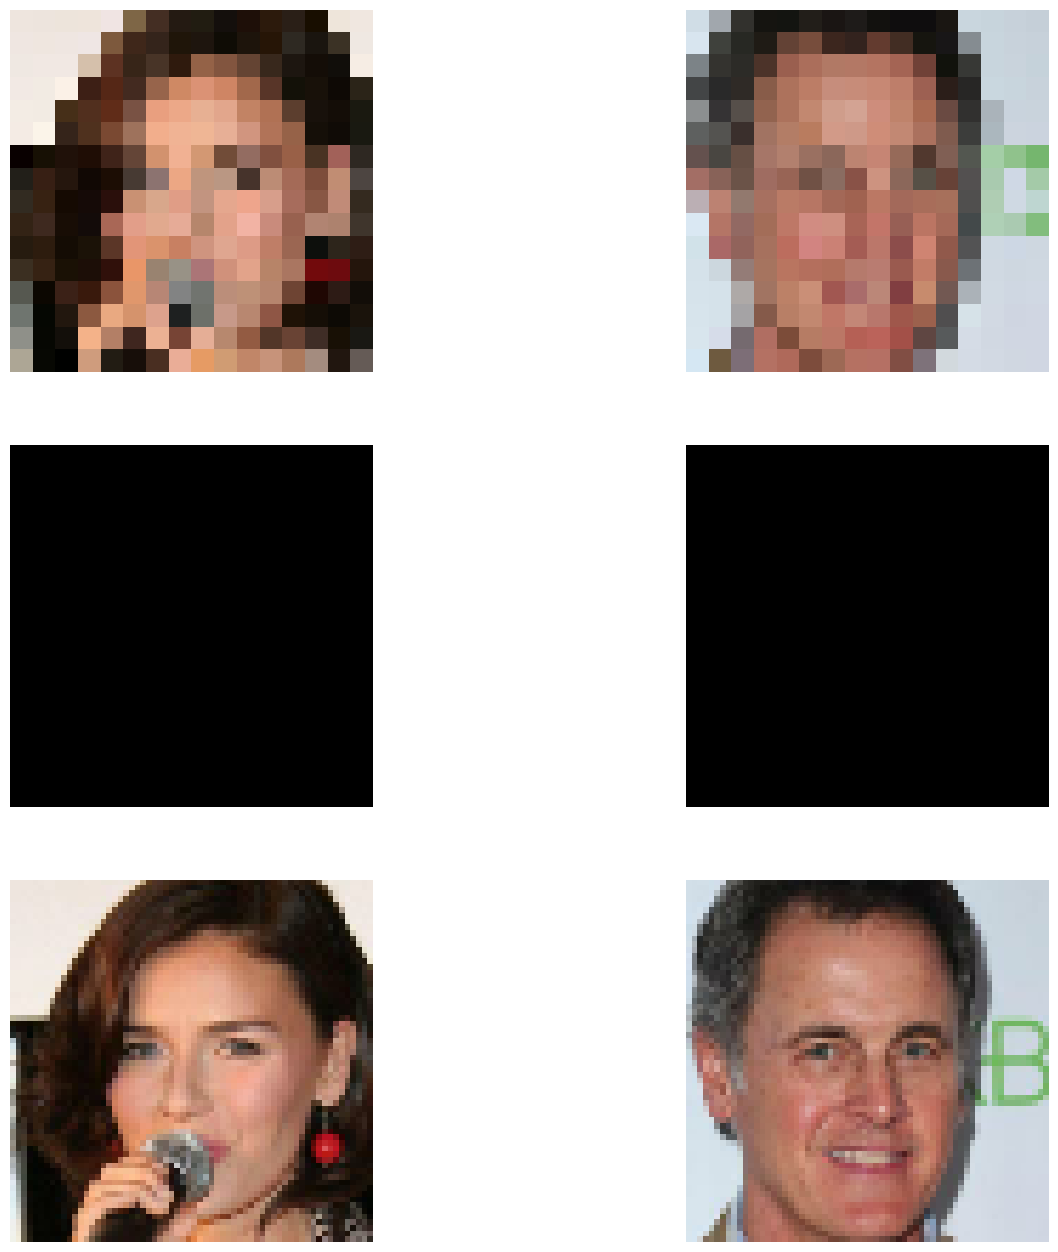

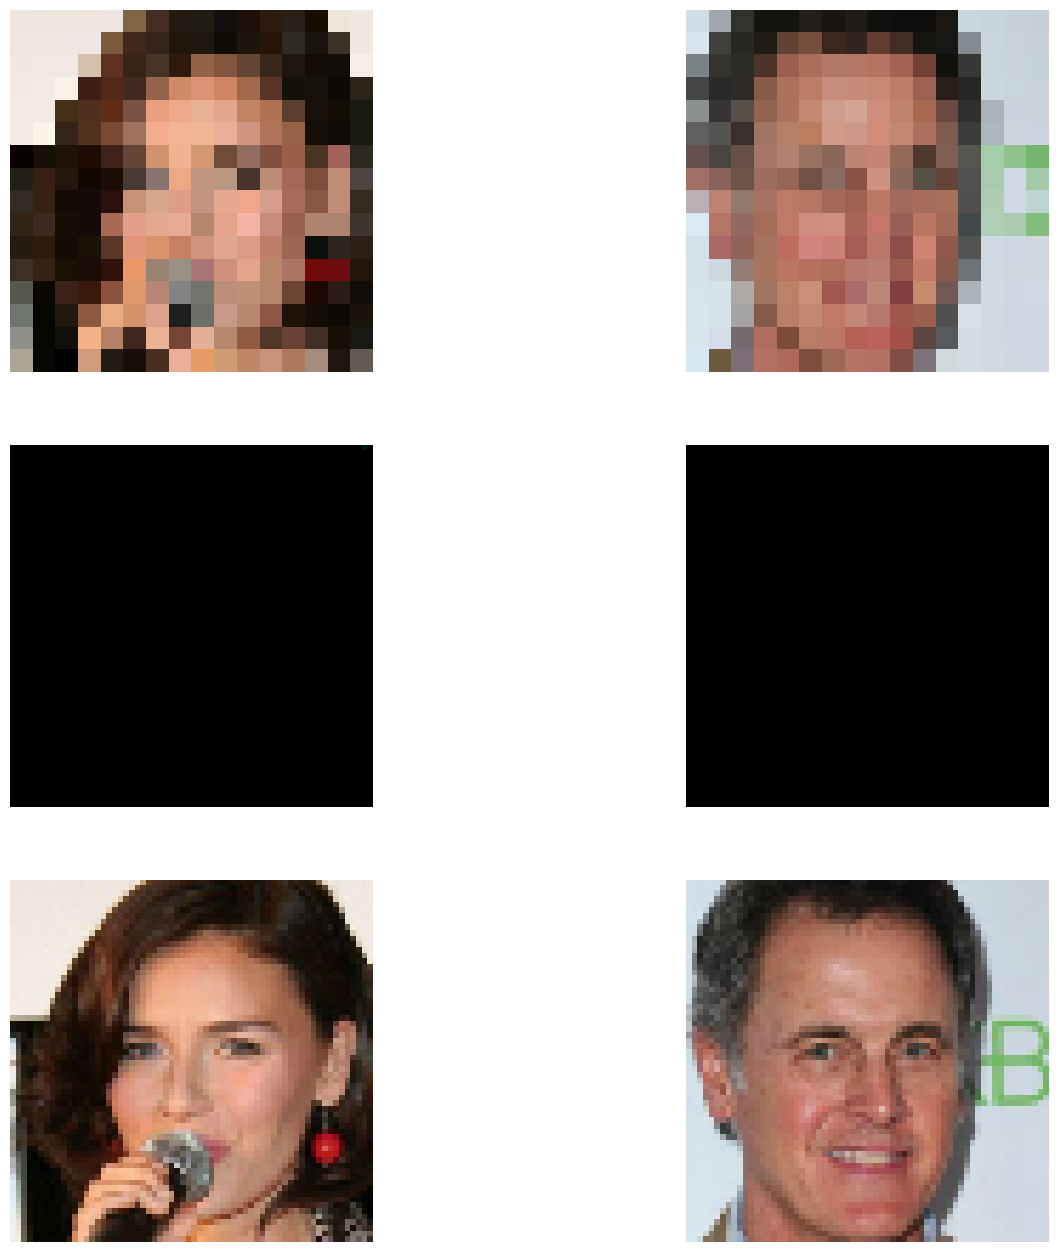

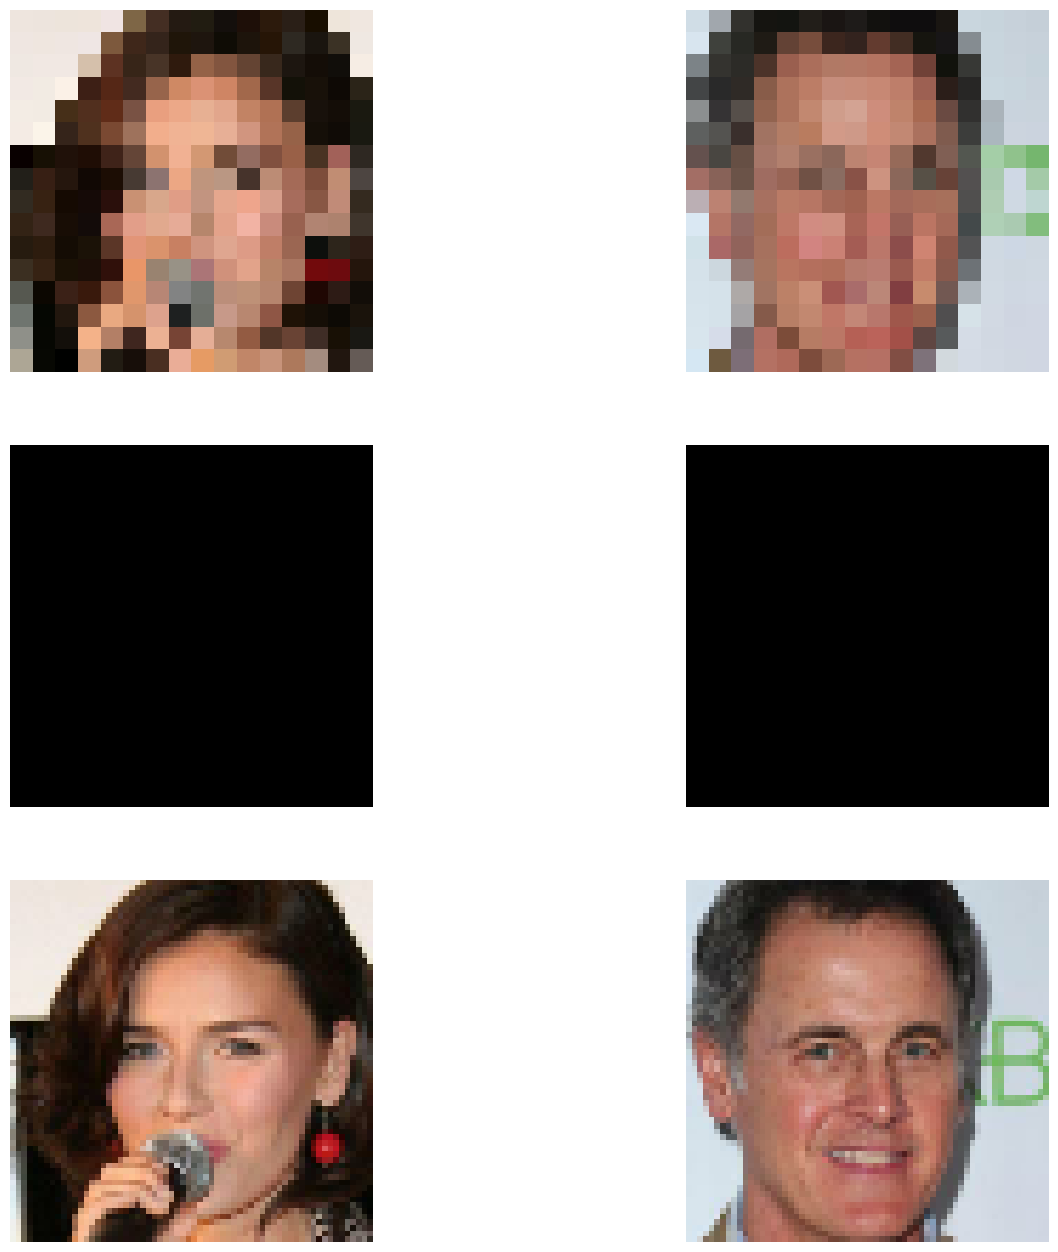

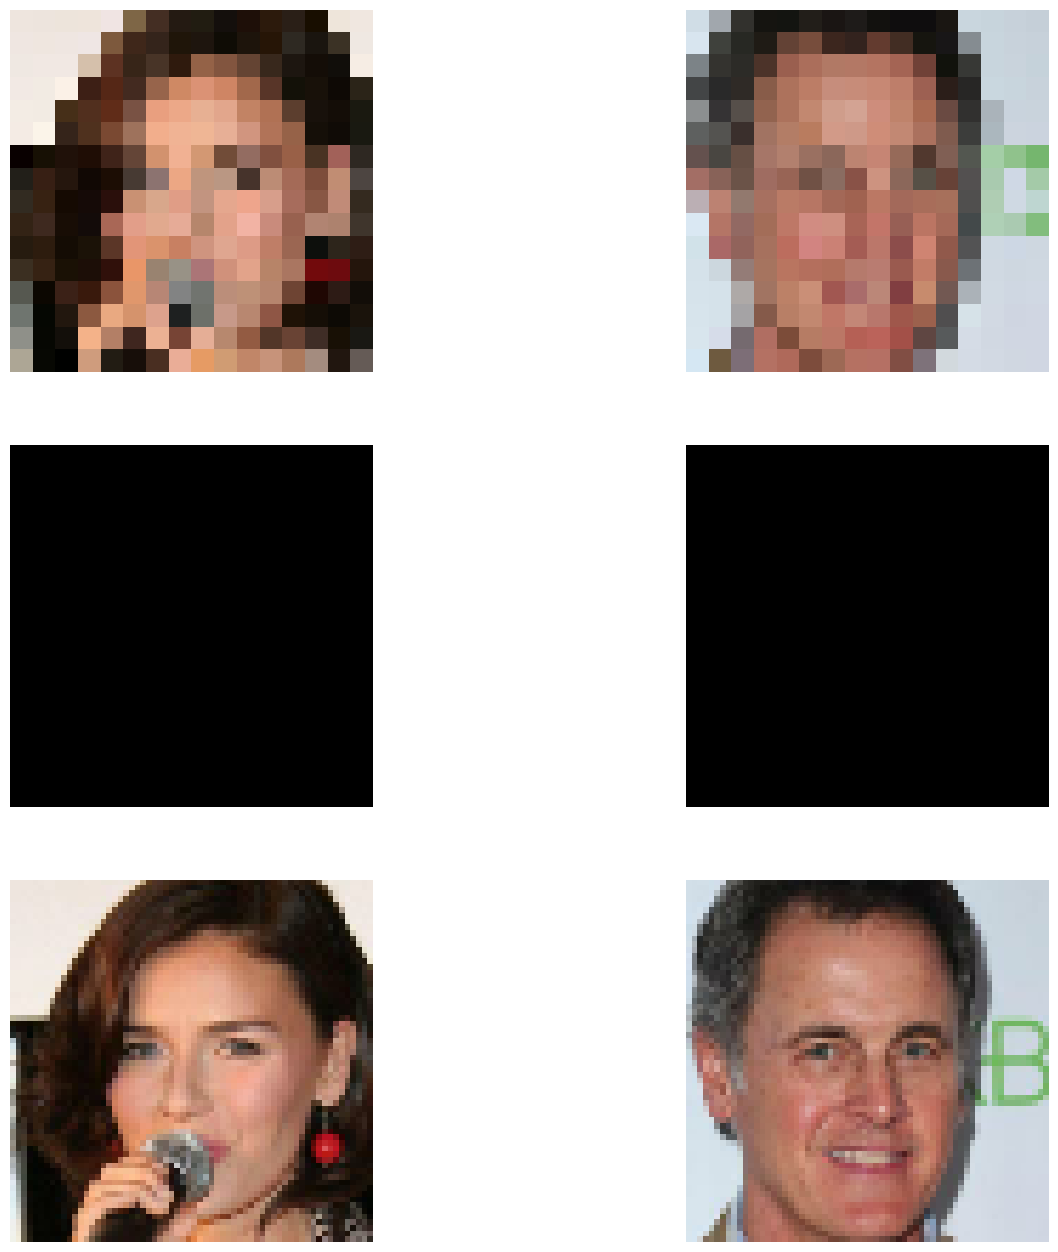

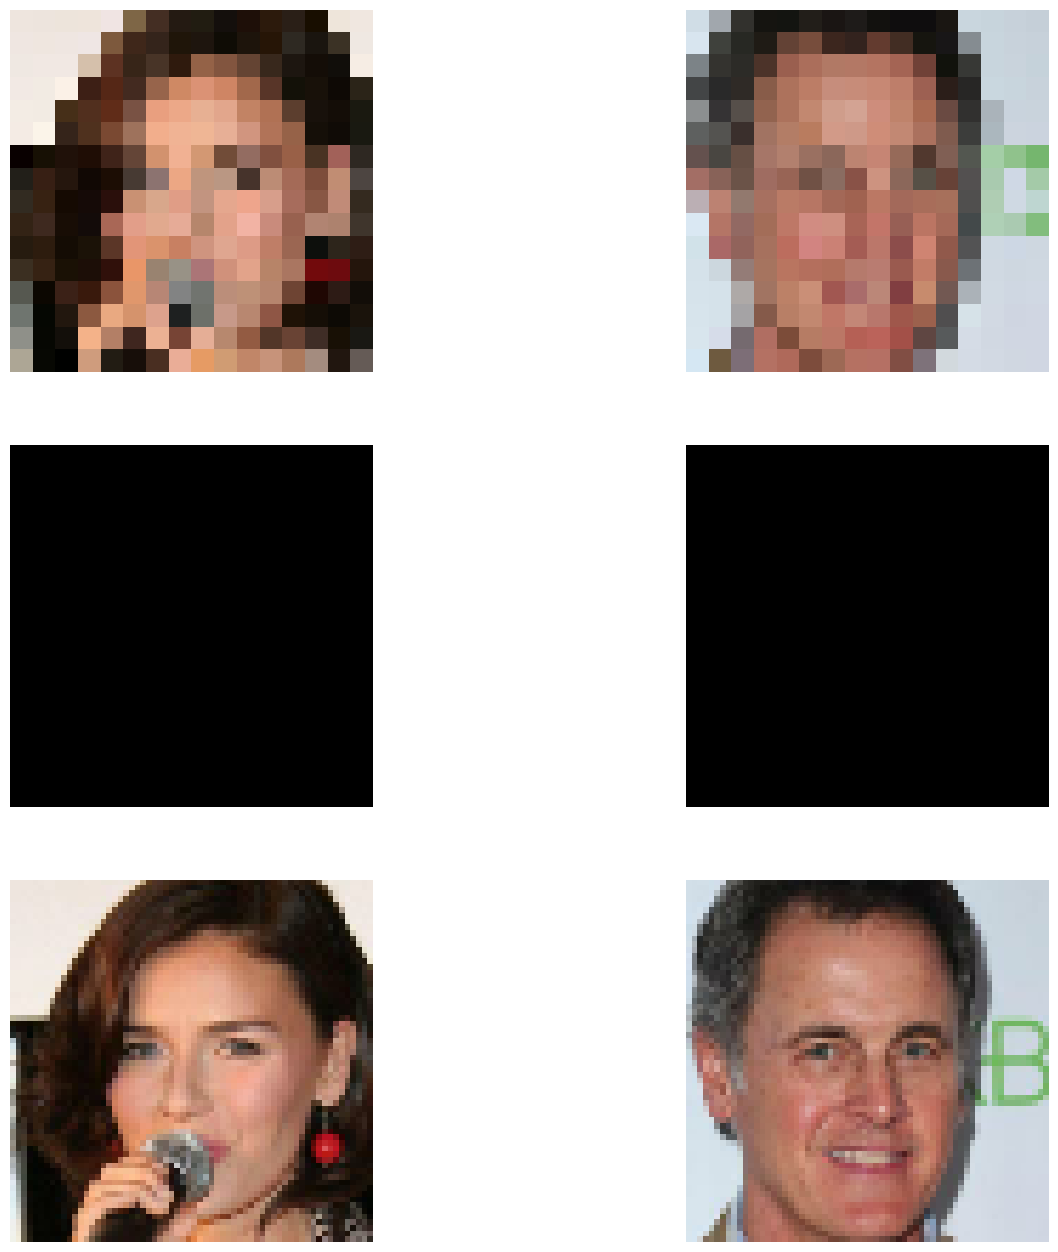

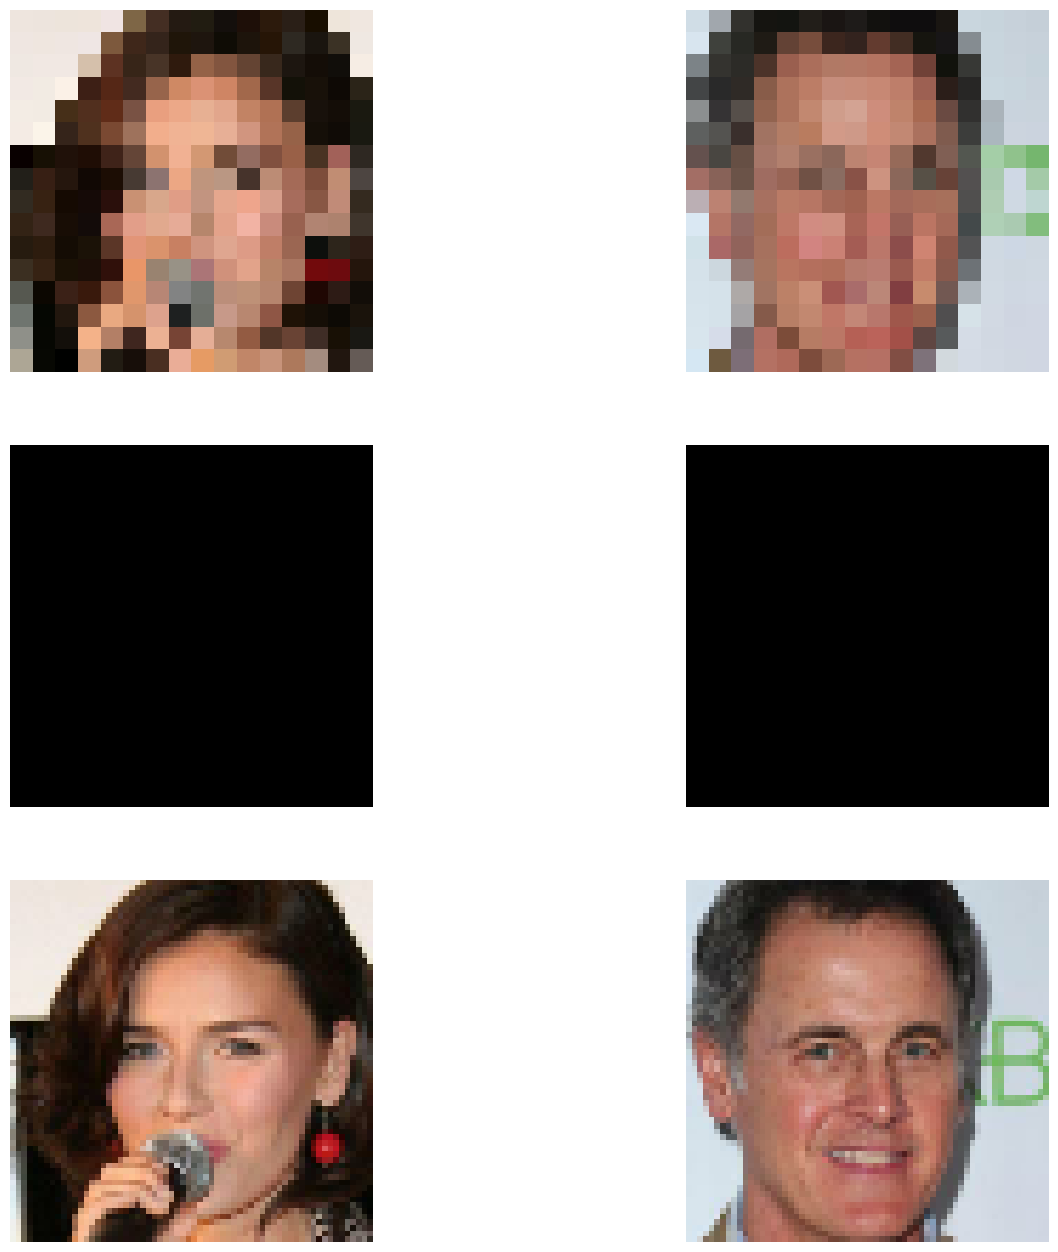

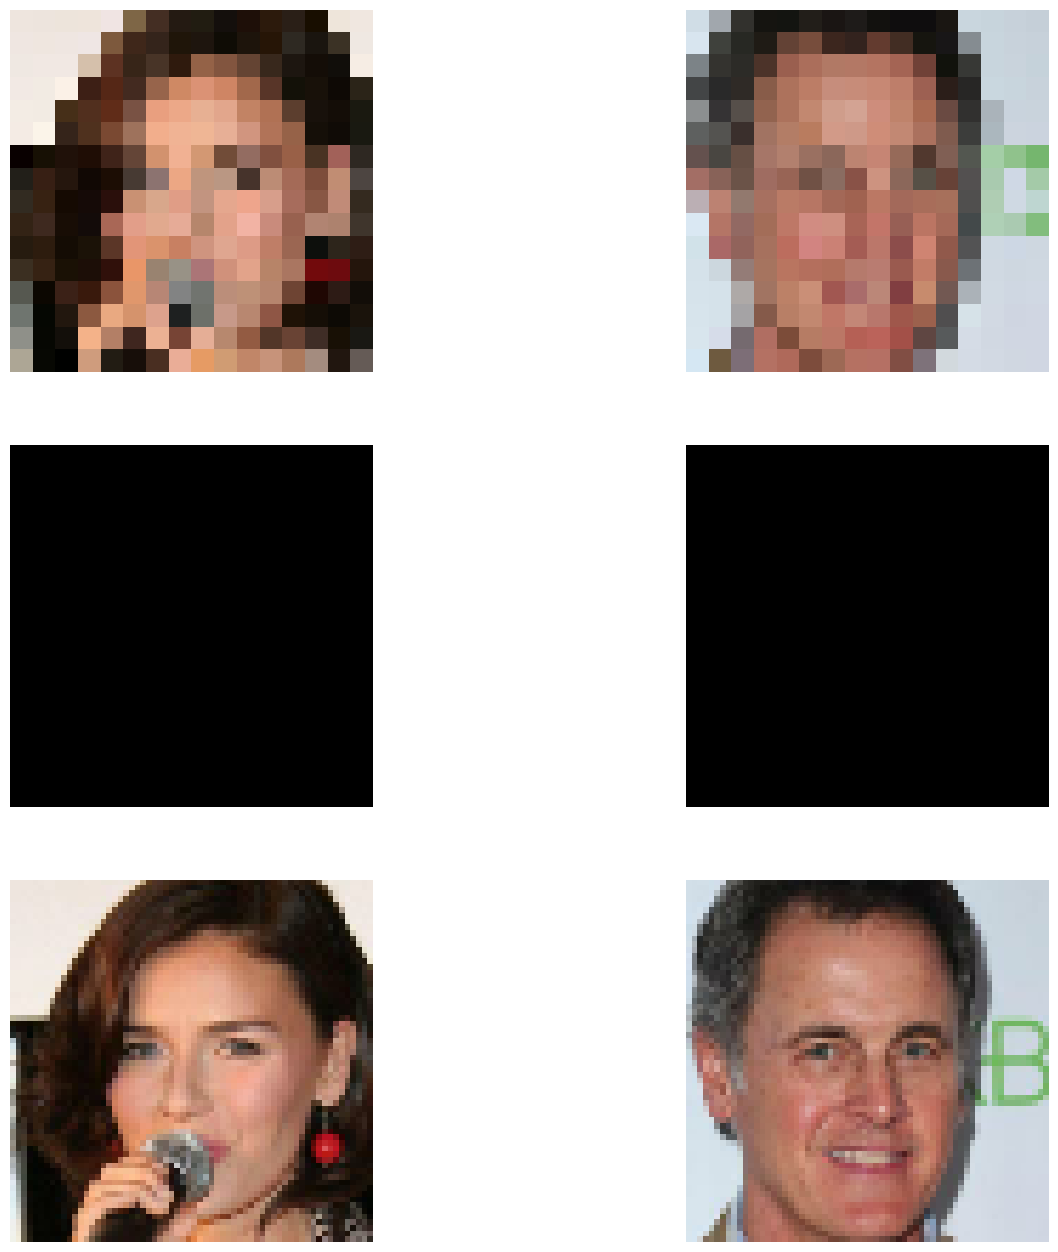

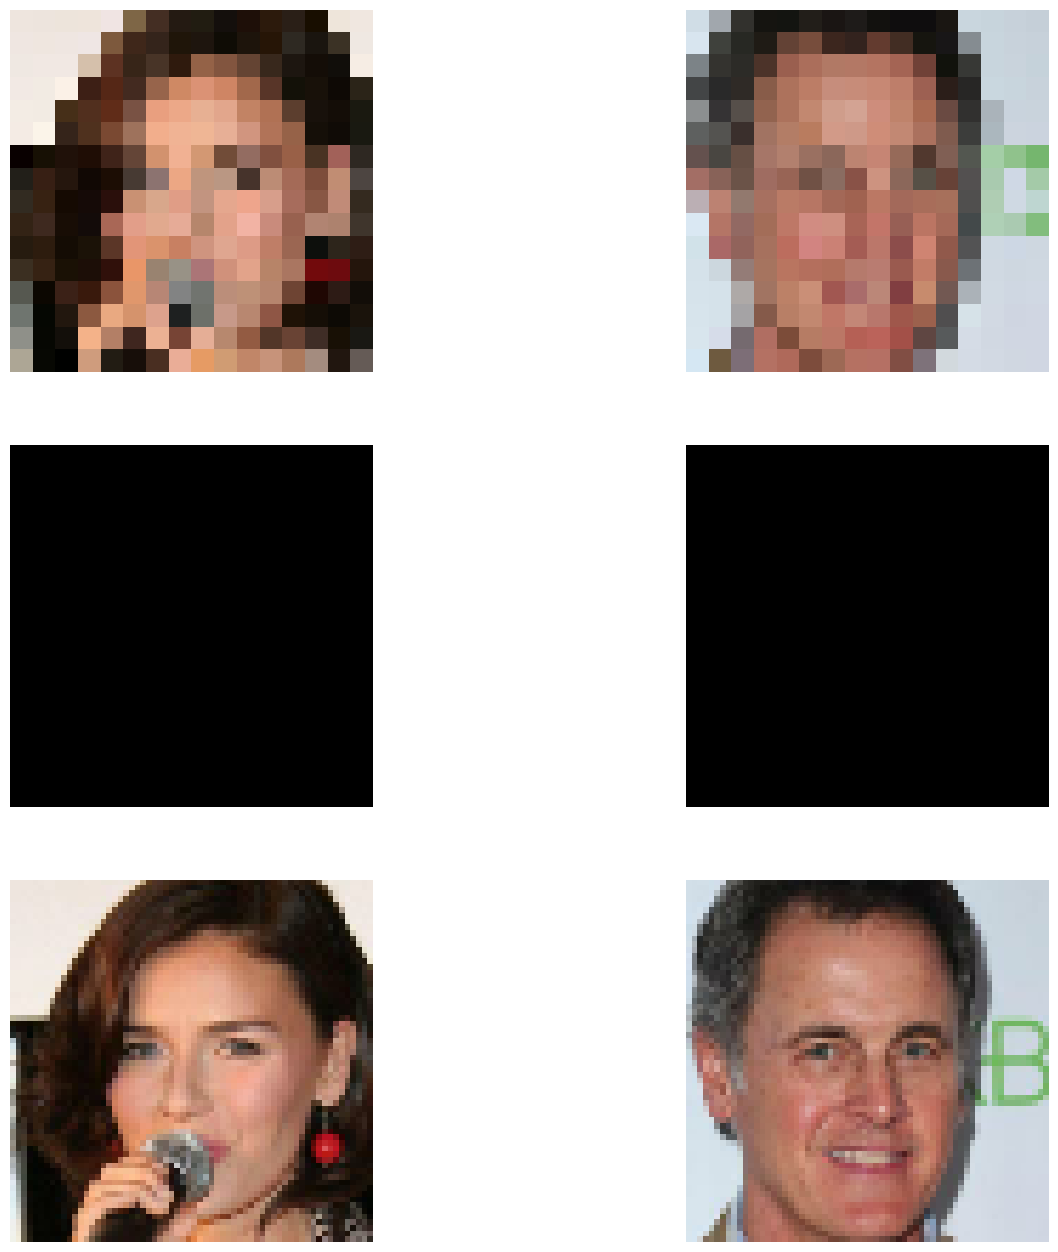

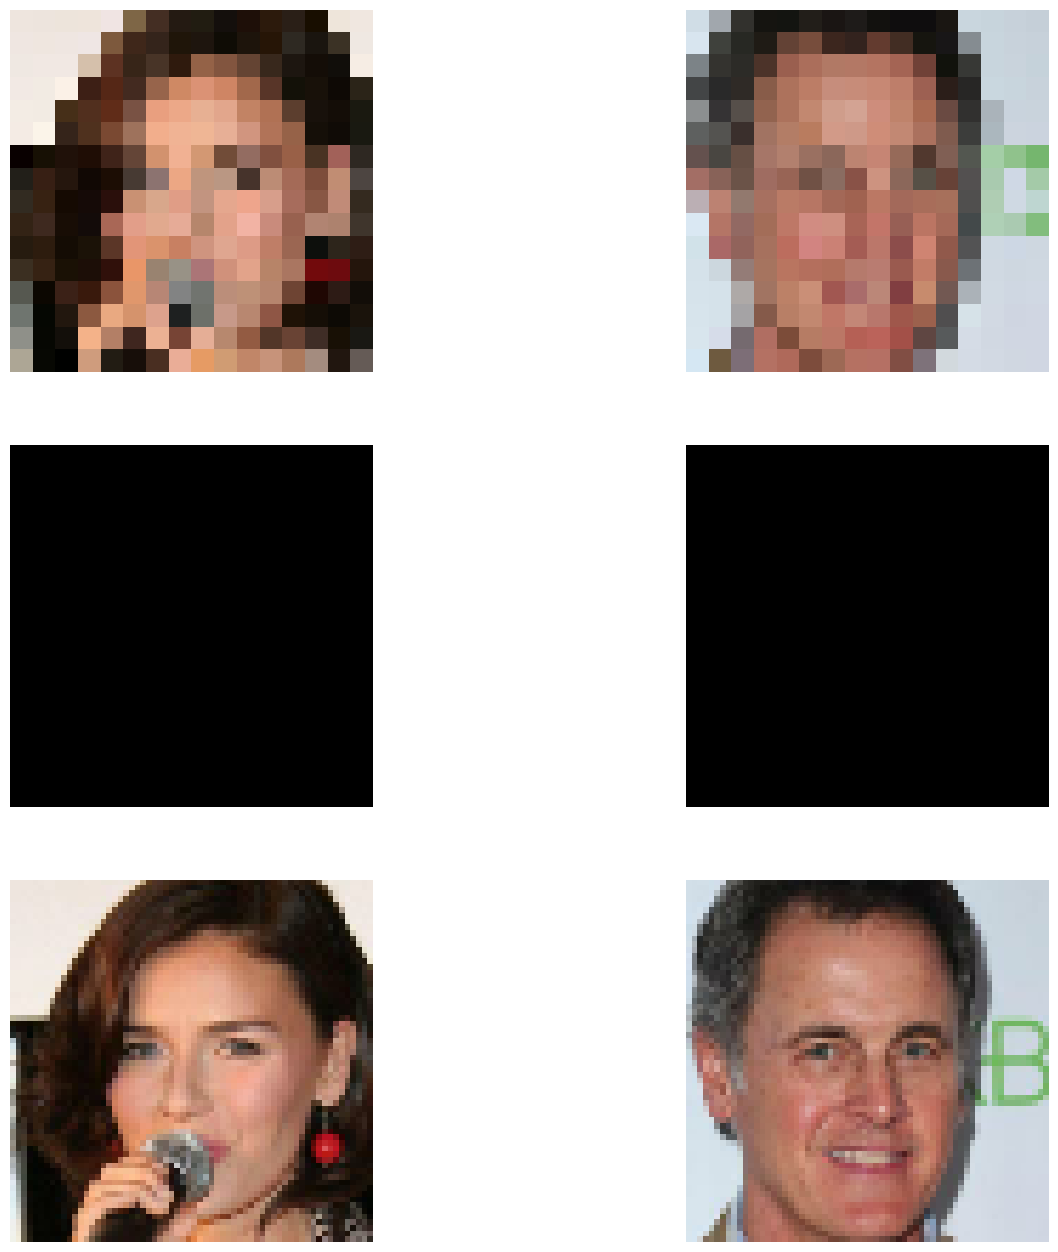

In [11]:
epochs = 36

gan = SRGAN(discriminator=discriminator, generator=srresnet)
gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=0.5),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=0.5),
    loss_disc=tf.keras.losses.BinaryCrossentropy(),
    loss_gen=content_loss
)

!mkdir generated

history = gan.fit(train_dataset, epochs=epochs, callbacks=[GANMonitor()])